In [56]:
# (auto) importing modules needed
import math, copy

import numpy  as np
import pandas as pd
import sympy  as sym
import matplotlib.pyplot as plt

from sympy import *

In [57]:
# (auto) multi-sectioning
def Multi_Sectioner( MAIN_BEAMS, MAIN_SUPPORTS, L_tinyBeam ):
     
    SUPPORTS   = MAIN_SUPPORTS['Support Type'].copy().values.tolist()
    BAYS_WIDTH = MAIN_BEAMS[      'L (mm)'   ].copy()
    
    Bays_Width, nPieces = [], []
    s = 0
    Supports = [ SUPPORTS[0] ]
    for i in BAYS_WIDTH:
        nPcs = int(i/L_tinyBeam)
        if nPcs >= 1:
            Bays_Width = Bays_Width + [L_tinyBeam]*nPcs
    
            if i%L_tinyBeam >= L_tinyBeam/2: 
                Bays_Width = Bays_Width + [i%L_tinyBeam]
                nPcs       = nPcs+1
            else                           : 
                Bays_Width[-1] = Bays_Width[-1]+i%L_tinyBeam 
        else:
            nPcs = 1
            Bays_Width = Bays_Width + [ i ]
    
        nPieces.append( nPcs )
        s = s+1
        Supports = Supports + ['mid']*(nPcs-1) + [SUPPORTS[s]]

    SUPPORTS_IDX = [0]
    for j in nPieces:  SUPPORTS_IDX = SUPPORTS_IDX + [ SUPPORTS_IDX[-1] + j ]
    
    return [ Supports, SUPPORTS_IDX, Bays_Width, nPieces ]

In [58]:
# (auto) Points & Connectivity Matrices
def PC( Bays_Width ): 
    
    # Points
    Xwalk = [0]
    for i in Bays_Width:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    Ywalk = [0] 
    X=len(Xwalk)
    Y=len(Ywalk) 
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X):
            x.append( int(Xwalk[i]) )
            y.append( int(Ywalk[j]) )
            index.append(idx)
            idx = idx+1
    Dict = {  'x': x
            , 'y': y  }
    Points = pd.DataFrame( data=Dict, index=index )
    
    # Connectivity
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X-1): 
            p0 = i + j*X
            p1 = p0 + 1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y
           }
    CnB = pd.DataFrame( data=Dict, index=index )
    
    return [ Points, CnB ]

In [59]:
# define a function called Shape
# to check shape of Beam
def  Beam_Shape( Points, CnB, BAYS_WIDTH, Bays_Width, Supports ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'r', 'deeppink', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'g', 'lime'    , y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'b', 'cyan'    , y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'b', 'b'       , y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'b', 'b'       , y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'Beam Shape', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in BAYS_WIDTH:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Beam_Shape.png', dpi=120) 
    plt.show()
    
    return None

In [60]:
# (auto) Finding Static Coefficients

# define a function called Static_Coeff 
# to find Static Analysis Coefficients: 
#
#   NOP:    Number Of Points
#   NOD:    Number of "Degrees of freedom"
#   RD:     Restrained "Degrees of freedom"
#   FD:     Free "Degrees of freedom"
#   NFD:    Number of Free "Degrees of Freedom"
#   NB:     Number of Beams
#   IndxB:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all beams

def Static_Coeff( Points, CnB, Bays_Width, Supports ):
    
    # NOP NOD RD FD NFD
    NOP=Points.shape[0]
    NOD=NOP*3
    
    RD=[]
    for i in Points.index:
        if   Supports[i]=='fixed' : LIST=[ 3*i+0, 3*i+1, 3*i+2 ]
        elif Supports[i]=='pinned': LIST=[ 3*i+0, 3*i+1        ]
        elif Supports[i]=='roller': LIST=[        3*i+1        ]
        elif Supports[i]=='free'  : LIST=[                     ]
        elif Supports[i]=='mid'   : LIST=[                     ]
        for i in LIST:
            RD.append(i)
    
    FD=[]
    for i in range(NOD):
        if i not in RD:
            FD.append(i)
    
    NRD=len(RD)
    NFD=len(FD)
    
    # NX
    NB = CnB.shape[0]
    
    # IndxB
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NB ):
        c0.append( 3*CnB.iloc[i,0]+0 )
        c1.append( 3*CnB.iloc[i,0]+1 )
        c2.append( 3*CnB.iloc[i,0]+2 )
        c3.append( 3*CnB.iloc[i,1]+0 )
        c4.append( 3*CnB.iloc[i,1]+1 )
        c5.append( 3*CnB.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxB = pd.DataFrame( data=Dict, index=index )
    
    return [NOP, NOD, RD, FD, NFD, NB, IndxB]

In [61]:
# (auto) multi-applying  ---  applying  E, A, I, W  to all pieces
def Make_All_Beams( Main_Beams, Bays_Width ):
    
    df      = Main_Beams.copy()
    E_Beams = df['E (KN/mm2)'       ].tolist()
    G_Beams = df['G (KN/mm2)'       ].tolist()
    A_Beams = df['A (mm2)'          ].tolist()
    I_Beams = df['I (mm4)'          ].tolist()
    Ks_Beams= df['Ks'               ].tolist()
    C_Beams = df['Color'            ].tolist()
    W_Beams = df['Dist Load (KN/mm)'].tolist()
    nPieces = df['nPieces'          ].tolist()     
    
    E_BEAMS, G_BEAMS, A_BEAMS, I_BEAMS, Ks_BEAMS, C_BEAMS, W_BEAMS = [],[],[],[],[],[],[]
    for i in range(df.shape[0]):
        E_BEAMS  =  E_BEAMS  +  [ E_Beams[i] ] * nPieces[i]
        G_BEAMS  =  G_BEAMS  +  [ G_Beams[i] ] * nPieces[i]
        A_BEAMS  =  A_BEAMS  +  [ A_Beams[i] ] * nPieces[i]
        I_BEAMS  =  I_BEAMS  +  [ I_Beams[i] ] * nPieces[i]
        Ks_BEAMS =  Ks_BEAMS +  [ Ks_Beams[i]] * nPieces[i]
        C_BEAMS  =  C_BEAMS  +  [ C_Beams[i] ] * nPieces[i]
        W_BEAMS  =  W_BEAMS  +  [ W_Beams[i] ] * nPieces[i]
        
    Beams = pd.DataFrame(
        columns = ['L (mm)','E (KN/mm2)','G (KN/mm2)','A (mm2)','I (mm4)','Ks','Color','Dist Load (KN/mm)'])
    Beams['E (KN/mm2)'] , Beams['G (KN/mm2)'          ] = E_BEAMS, G_BEAMS
    Beams['A (mm2)'   ] , Beams['I (mm4)'], Beams['Ks'] = A_BEAMS, I_BEAMS, Ks_BEAMS
    Beams['Color'     ] , Beams['Dist Load (KN/mm)'   ] = C_BEAMS, W_BEAMS
    Beams['L (mm)'    ] = Bays_Width
    
    return Beams

In [62]:
def Beam_Color( Beams ):
    
    Colors = ['dodgerblue','deeppink','lawngreen','orange','purple','olive','pink']
    df = Beams[['E (KN/mm2)','A (mm2)','I (mm4)']].copy()

    df_Set = df.copy().drop_duplicates()
    df_Set.index = range( df_Set.shape[0] )
    df_Set['Color'] = Colors[:df_Set.shape[0]]

    C = []
    for j in range(df.shape[0]):
        A = df.loc[j,'A (mm2)']
        I = df.loc[j,'I (mm4)']
        for i in range(df_Set.shape[0]):
            set_A, set_I, set_C = df_Set.loc[i,['A (mm2)','I (mm4)','Color']]
            if set_A==A and set_I==I: C.append(set_C)
                
    return C

In [63]:
# define a function called Plot_Sections
# to check sections of beam
def Plot_Sections( Points, CnB, BAYS_WIDTH, Bays_Width, Supports, All_Beams ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        c = All_Beams.loc[i,'Color']
        ax.plot( x, y, lw=4, c=c, ls='-', alpha=0.85 )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec='lightgray', fc='lightgray', alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec='lightgray', fc='lightgray', alpha=0.75 )
        
    # title
    plt.title( 'Beam Sections', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in BAYS_WIDTH:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Beam_Sections.png', dpi=120)
    plt.show()

In [64]:
# define a function called Beam_Load_Shape
# to check load of beams
def  Beam_Dist_Load_Shape( Points, CnB, BAYS_WIDTH, Bays_Width, Supports, All_Beams, DIST_LOADS ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    W = All_Beams['Dist Load (KN/mm)'].copy()
    W = 0.5*W / W.max()  
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        y2 = [ y0+W[i], y1+W[i] ]
        ax.fill_between(x, y, y2, color='cyan')
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.06
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.06
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            
    for i in range(len(BAYS_WIDTH)):
        x = sum(BAYS_WIDTH[:i]) + BAYS_WIDTH[i]/2 -sum(Bays_Width)/20
        y = 0.1 + 0.5*DIST_LOADS[i]/max(DIST_LOADS)
        plt.text( x, y, str(DIST_LOADS[i]), font='MV BOLI', fontsize=14 )
        
    # title
    plt.title( 'Distributed Loads', ha='center', va='center', ma='center', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in BAYS_WIDTH:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Distributed_Loads.png', dpi=120)
    plt.show()

In [65]:
# (auto) Nodal Forces
def Nodal_Forces( Points, Point_Loads, NOD, Main_Beams ): 
    
    df = Main_Beams.copy()
    nPieces = df['nPieces'].tolist()
    
    # Multi-Sectioning
    PL = [0]
    for i in range(df.shape[0]):
        PL[-1] = Point_Loads[i]
        PL = PL + [0]*nPieces[i]
    PL[-1] = Point_Loads[-1]
    Point_Loads = PL
    
    NF = pd.DataFrame( columns=['Load','Dummy'], index=range(NOD) ).replace( float('nan'), 0.0 )
    for  i in Points.index:  NF.loc[3*i+1,'Load'] = -Point_Loads[i]
    #for i in Points.index:  NF.loc[3*i  ,'Load'] = +0.001 # disturbing load
    return NF

In [66]:
# checking NF of beams
def NF_Shape( Points, CnB, BAYS_WIDTH, Bays_Width, Supports, NF ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )
    
    y_Max = max(abs(NF['Load']))
    w = sum(Bays_Width)/85
    for i in NF.index: 
        if  i % 3 == 1:
            x = Points.loc[ (i-1)/3, 'x' ]
            y = NF.loc[i,'Load'] / y_Max *.75
            if   y>0:  
                ax.arrow( x, -y, 0, y, head_width=.15, width=w, fc='pink', ec='deeppink'   )
                plt.text( x-1.5*w, -y-.20, str(int(+NF.loc[i,'Load'])), font='MV BOLI', fontsize=14 )
            elif y<0: 
                ax.arrow( x, -y, 0, y, head_width=.15, width=w, fc='cyan', ec='dodgerblue' )  
                plt.text( x-1.5*w, -y+.05, str(int(-NF.loc[i,'Load'])), font='MV BOLI', fontsize=14 )  
            

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray', y-0.0 
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'NF', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in BAYS_WIDTH:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('NF.png', dpi=120)
    plt.show()
    
    return None

In [67]:
# (auto) Elastic Stiffness Matrices 

def T_frame( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6' ] 
    c = {  'c1': [  c  ,  s  ,   0  ,  0  ,  0  ,   0  ]  
         , 'c2': [ -s  ,  c  ,   0  ,  0  ,  0  ,   0  ]
         , 'c3': [  0  ,  0  ,   1  ,  0  ,  0  ,   0  ]
         , 'c4': [  0  ,  0  ,   0  ,  c  ,  s  ,   0  ]
         , 'c5': [  0  ,  0  ,   0  , -s  ,  c  ,   0  ]
         , 'c6': [  0  ,  0  ,   0  ,  0  ,  0  ,   1  ]
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T

def ke_frame_DSM( A, E, I, L ):
    EI, EA, L2, L3 = E*I, E*A, L**2, L**3
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    c = {  'c1': [ EA/L   , 0        ,  0      , -1*EA/L,  0       ,  0       ]
         , 'c2': [ 0      , 12*EI/L3 ,  6*EI/L2,  0     , -12*EI/L3,  6*EI/L2 ]
         , 'c3': [ 0      , 6*EI/L2  ,  4*EI/L ,  0     , -6*EI/L2 ,  2*EI/L  ]
         , 'c4': [-1*EA/L , 0        ,  0      ,  EA/L  ,  0       ,  0       ]
         , 'c5': [ 0      , -12*EI/L3, -6*EI/L2,  0     ,  12*EI/L3, -6*EI/L2 ]  
         , 'c6': [ 0      , 6*EI/L2  , 2*EI/L  ,  0     , -6*EI/L2 ,  4*EI/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def ke_frame_TimoShenko( A, E, G, I, L, Ks ):
    EI, EA, L2, L3 = E*I, E*A, L**2, L**3
    m = (12*EI) / (L2*G*A*Ks)
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    c = {  'c1': [  EA/L,    0            ,   0                   ,  -EA/L,    0            ,   0                     ]
         , 'c2': [    0 ,   12*EI/L3/(1+m),   6*EI/L2/(1+m)       ,   0   ,  -12*EI/L3/(1+m),   6*EI/L2/(1+m)         ]
         , 'c3': [    0 ,    6*EI/L2/(1+m),   4*EI*(1+m/4)/L/(1+m),   0   ,   -6*EI/L2/(1+m),   2*EI*(1-m/2)/L/(1+m)  ]
         , 'c4': [ -EA/L,    0            ,   0                   ,   EA/L,    0            ,   0                     ]
         , 'c5': [    0 ,  -12*EI/L3/(1+m),  -6*EI/L2/(1+m)       ,   0   ,   12*EI/L3/(1+m),  -6*EI/L2/(1+m)         ]
         , 'c6': [    0 ,    6*EI/L2/(1+m),   2*EI*(1-m/2)/L/(1+m),   0   ,   -6*EI/L2/(1+m),   4*EI*(1+m/4)/L/(1+m)  ]
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def C_frame_DSM( L ):
    L2, L3 = L**2, L**3
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    
    c = {  'c1': [  1,  0,  0,  0,   0 ,    0   ]
         , 'c2': [  0,  0,  1,  0,   0 ,    0   ]
         , 'c3': [  0,  0,  0,  1,   0 ,    0   ]
         , 'c4': [  1,  L,  0,  0,   0 ,    0   ]
         , 'c5': [  0,  0,  1,  L,  L2 ,   L3   ]
         , 'c6': [  0,  0,  0,  1,  2*L,  3*L2  ]
         }  
    C = pd.DataFrame( data=c , index=r )
    C = C.T
    
    return C

def C_frame_TimoShenko( A, E, G, I, L, Ks ):
    L2, L3 = L**2, L**3
    #m = (12*EI) / (L2*G*A*Ks)
    EA   = E*A
    EI   = E*I
    GAK  = G*A*Ks
    alfa = EI/GAK 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    
    c = {  'c1': [  1,  0,  0,  0,   0 ,        0       ]
         , 'c2': [  0,  0,  1,  0,   0 ,        0       ]
         , 'c3': [  0,  0,  0,  1,   0 ,     6*alfa     ]
         , 'c4': [  1,  L,  0,  0,   0 ,        0       ]
         , 'c5': [  0,  0,  1,  L,  L2 ,       L3       ]
         , 'c6': [  0,  0,  0,  1,  2*L,  3*(L2+2*alfa) ]
         }  
    C = pd.DataFrame( data=c , index=r )
    C = C.T
    
    return C

def N_frame_DSM( ):
    x = sym.symbols('x') 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    n = {  'c1': [  1,  x,  0,  0,   0  ,         0        ]
         , 'c2': [  0,  0,  1,  x,  x**2,       x**3       ]
         }  
    N = pd.DataFrame( data=n , index=r )
    N = N.T
    
    return N

def N_frame_TimoShenko( A, E, G, I, L, Ks ):
    x = sym.symbols('x')
    EI   = E*I
    GAK  = G*A*Ks
    alfa = EI/GAK 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ]     
    n = {  'c1': [  1,  x,  0,  0,   0  ,         0        ]
         , 'c2': [  0,  0,  1,  x,  x**2,       x**3       ]
         , 'c3': [  0,  0,  0,  1,  2*x ,  3*(x**2+2*alfa) ]
         }  
    N = pd.DataFrame( data=n , index=r )
    N = N.T
    
    return N

def Up_frame_DSM( E, I, L, w ):
    q = -w
    x = sym.symbols('x')
    L2 = L**2
    EI = E*I    
    r = [ 0 ]
    u = {  'c1': [  0  ]
         , 'c2': [  q*L2 * x**2 * (1-x/L)**2 / (24*EI) ]
         }  
    Up = pd.DataFrame( data=u , index=r )
    Up = Up.T
    
    return Up

def Up_frame_TimoShenko( A, E, G, I, L, Ks, w ):
    q = -w
    x = sym.symbols('x')
    L2 = L**2
    EI   = E*I
    GAK  = G*A*Ks
    alfa = EI/GAK
    
    r = [ 0 ] 
    
    u = {  'c1': [  0  ]
         , 'c2': [  q*L2 * x**2 * (1-x/L)**2 / (24*EI)  +  q*L*x * (1-x/L) / (2*GAK)  ]
         , 'c3': [  q*L2*x * (1-2*x/L) * (1-x/L) / (12*EI)  ]
         }  
    Up = pd.DataFrame( data=u , index=r )
    Up = Up.T
    
    return Up

''' 
import sympy as sym
import math
x = sym.symbols('x')

w, A, E, G, I, L, Ks = 1,1,1,1,1,1,1

Up = Up_frame( x, w, A, E, G, I, L, Ks )

N = N_frame( x, A, E, G, I, L, Ks )
C = C_frame(    A, E, G, I, L, Ks )
C_inv = np.linalg.inv(C)
Uh = (N @ C_inv) 
ub = pd.DataFrame(TB[0] @ uB[0])
ub.index = range(6)
Uh = Uh @ ub
U  = Up + Uh

u = U.loc['c1',0];  du_dx = sym.diff(u,x)
v = U.loc['c2',0];  dv_dx = sym.diff(v,x)
t = U.loc['c3',0];  dt_dx = sym.diff(t,x)

N = E*A * du_dx
V = G*A*Ks * ( dv_dx - t )
M = E*I * dt_dx
M.evalf( subs={x:10} )
''' 

" \nimport sympy as sym\nimport math\nx = sym.symbols('x')\n\nw, A, E, G, I, L, Ks = 1,1,1,1,1,1,1\n\nUp = Up_frame( x, w, A, E, G, I, L, Ks )\n\nN = N_frame( x, A, E, G, I, L, Ks )\nC = C_frame(    A, E, G, I, L, Ks )\nC_inv = np.linalg.inv(C)\nUh = (N @ C_inv) \nub = pd.DataFrame(TB[0] @ uB[0])\nub.index = range(6)\nUh = Uh @ ub\nU  = Up + Uh\n\nu = U.loc['c1',0];  du_dx = sym.diff(u,x)\nv = U.loc['c2',0];  dv_dx = sym.diff(v,x)\nt = U.loc['c3',0];  dt_dx = sym.diff(t,x)\n\nN = E*A * du_dx\nV = G*A*Ks * ( dv_dx - t )\nM = E*I * dt_dx\nM.evalf( subs={x:10} )\n"

In [68]:
def Analyze_Beam_TimoShenko( NF,  NOD,  FD, KE, QF
                           , NB, IndxB, TB, keB, KeB, qfB, All_Beams ): 
            
    ## k  kX KX  
    K=KE
            
    kB, KB = [],[];
    for i in range(0,NB): 
        kB.append( keB[i] )
        KB.append( KeB[i] )    
     
    # Kred
    Kred = K.iloc[FD,FD]
        
    # U
    U = np.zeros([NOD,2],'float64')
    U = pd.DataFrame( U,columns = ['dis','Dummy'] ) 
         
    ## Gauss Ellimination  ax=b => x=?
    a = Kred.values
    b = (  NF.loc[FD,'Load'] - QF.loc[FD,'Load']  ).values
    n = len(b)
    x = np.zeros(n,'float64')

    #    Forward Elimination
    for k in range(n-1):
        for i in range(k+1,n):
            fctr = a[i,k] / a[k,k]
            for j in range(k,n):
                a[i,j] = a[i,j] - fctr*a[k,j]
            b[i] = b[i] - fctr*b[k]
    
    #    Back Substitution
    x[n-1] = b[n-1] / a[n-1,n-1]
    for i in range(n-2,-1,-1):
        Sum = b[i]
        for j in range(i+1,n):
            Sum = Sum - a[i,j]*x[j]
        x[i] = Sum / a[i,i]
           
    # U    
    U.loc[FD,'dis'] = x.copy()
        
    ## member forces
      
    #    Beam
    uB,UB,qB = [],[],[]
    New_X, New_Y, New_V, New_M = [],[],[],[]
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i] 
        k    = kB[i] 
        UB.append(  U.loc[Indx,'dis'].values  )    
        uB.append( T @ UB[-1] )
        #qB.append( k @ uB[-1] ) 
            
        x = sym.symbols('x')
        L = All_Beams.loc[i,'L (mm)']
        E = All_Beams.loc[i,'E (KN/mm2)']
        G = All_Beams.loc[i,'G (KN/mm2)']
        A = All_Beams.loc[i,'A (mm2)']
        I = All_Beams.loc[i,'I (mm4)']
        Ks= All_Beams.loc[i,'Ks']
        w = All_Beams.loc[i,'Dist Load (KN/mm)']

        Up = Up_frame_TimoShenko( A, E, G, I, L, Ks, w )
        N  = N_frame_TimoShenko(  A, E, G, I, L, Ks    )
        C  = C_frame_TimoShenko(  A, E, G, I, L, Ks    )
        C_inv = np.linalg.inv(C)
        Uh = (N @ C_inv) 
        ub = pd.DataFrame( uB[i] )
        ub.index = range(6)
        Uh  = Uh @ ub
        Uph = Up + Uh

        u = Uph.loc['c1',0];  du_dx = sym.diff(u,x)   
        v = Uph.loc['c2',0];  dv_dx = sym.diff(v,x)
        t = Uph.loc['c3',0];  dt_dx = sym.diff(t,x)   # theta
        
        N =  E*A * du_dx
        V = -G*A*Ks * ( dv_dx - t )
        M =  E*I * dt_dx
        
        try   : X_init = New_X[-1]
        except: X_init = 0
        for l in np.arange( 0, L, 10 ).tolist()+[L]:
            new_x = X_init + l                   ;  New_X.append( new_x ) 
            new_y = float( v.evalf( subs={x:l} ));  New_Y.append( new_y )
            new_v = float( V.evalf( subs={x:l} ));  New_V.append( new_v )
            new_m = float( M.evalf( subs={x:l} ));  New_M.append( new_m )
        
        N0 = float( N.evalf( subs={x:0} ))
        N1 = float( N.evalf( subs={x:L} ))
        
        V0 = float( V.evalf( subs={x:0} ))
        V1 = float( V.evalf( subs={x:L} ))
        
        M0 = float( M.evalf( subs={x:0} ))
        M1 = float( M.evalf( subs={x:L} ))
        
        NVM = pd.Series([N0,-V0,M0,N1,V1,M1])
        NVM.index=['c1','c2','c3','c4','c5','c6']
        
        qB.append( NVM )
        print(i)
        
    df_XYVM = pd.DataFrame()
    df_XYVM['X'] = New_X
    df_XYVM['Y'] = New_Y
    df_XYVM['V'] = New_V
    df_XYVM['M'] = New_M
    df_XYVM = df_XYVM.drop_duplicates()
    df_XYVM.index = range(df_XYVM.shape[0])
    
    ## Reactions 
    R = np.zeros([NOD,2],'float64')
    R = pd.DataFrame( R, columns = ['Reactions','Dummy'] )
        
    #   Beam
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i]
        q    = qB[i]
        Q    = T.T @ q  
        R.loc[Indx,'Reactions'] = R.loc[Indx,'Reactions'] + Q.values   
    
    return [ qB, R, U, df_XYVM ]

In [69]:
# (auto) defining a function called KeQf
# to form:
#    Elastic Stiffness Matrices, Ke, for all elements
#    External Distributed Loads Matrix, Qf
def KeQf(  Points,  NOD
         , CnB, NB, IndxB
         , All_Beams, Method ):
    
    # Empty Ke Qf
    KE = np.zeros([NOD,NOD],'float64')
    KE = pd.DataFrame( KE,columns = np.arange(0,NOD) )
    QF = np.zeros([NOD,2],'float64')
    QF = pd.DataFrame( QF,columns = ['Load','Dummy'] )
    
    # Assigning Properties  
    LB,  TB,  keB,  KeB, qfB, QfB  =  [],[],[],[],[],[]
        
    for i in range(0,NB): 
        dx = Points.iloc[CnB.iloc[i,1],0]-Points.iloc[CnB.iloc[i,0],0]
        dy = Points.iloc[CnB.iloc[i,1],1]-Points.iloc[CnB.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LB.append(L)
        E  = All_Beams.loc[i,'E (KN/mm2)']; 
        G  = All_Beams.loc[i,'G (KN/mm2)'];      
        A  = All_Beams.loc[i,'A (mm2)'];         
        I  = All_Beams.loc[i,'I (mm4)'];         
        Ks = All_Beams.loc[i,'Ks'];          
        w  = All_Beams.loc[i,'Dist Load (KN/mm)'];          
        c,s= dx/L, dy/L;
        T  = T_frame(c,s);           TB.append(T)
        Indx = list(IndxB.iloc[i,:])
        qf   = [0,w*L/2,w*L**2/12,0,w*L/2,-w*L**2/12] 
        Dict = {'qf':qf, 'dummy':np.zeros(6,'float')}
        qf = pd.DataFrame( data=Dict, index=range(0,6) ) 
        qfB.append(qf)
        Qf = T.T @ qf['qf'].values;                              
        QF.loc[Indx,'Load'] = QF.loc[Indx,'Load'] + Qf.values;
        if   Method == 'DSM'       :  ke = ke_frame_DSM(A,E,I,L) 
        elif Method == 'TimoShenko':  ke = ke_frame_TimoShenko(A,E,G,I,L,Ks) 
        keB.append(ke)   
        Ke = T.T @ ke @ T;           KeB.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values;
    
    return [ KE,QF, LB,TB,keB,KeB,qfB ]

In [70]:
def Analyze_Beam_DSM( NF,  NOD,  FD, KE, QF
                           , NB, IndxB, TB, keB, KeB, qfB, All_Beams ): 
            
    ## k  kX KX  
    K=KE
            
    kB, KB = [],[];
    for i in range(0,NB): 
        kB.append( keB[i] )
        KB.append( KeB[i] )    
     
    # Kred
    Kred = K.iloc[FD,FD]
        
    # U
    U = np.zeros([NOD,2],'float64')
    U = pd.DataFrame( U,columns = ['dis','Dummy'] ) 
         
    ## Gauss Ellimination  ax=b => x=?
    a = Kred.values
    b = (  NF.loc[FD,'Load'] - QF.loc[FD,'Load']  ).values
    n = len(b)
    x = np.zeros(n,'float64')

    #    Forward Elimination
    for k in range(n-1):
        for i in range(k+1,n):
            fctr = a[i,k] / a[k,k]
            for j in range(k,n):
                a[i,j] = a[i,j] - fctr*a[k,j]
            b[i] = b[i] - fctr*b[k]
    
    #    Back Substitution
    x[n-1] = b[n-1] / a[n-1,n-1]
    for i in range(n-2,-1,-1):
        Sum = b[i]
        for j in range(i+1,n):
            Sum = Sum - a[i,j]*x[j]
        x[i] = Sum / a[i,i]
           
    # U    
    U.loc[FD,'dis'] = x.copy()
        
    ## member forces
      
    #    Beam
    uB,UB,qB = [],[],[]
    New_X, New_Y, New_V, New_M = [],[],[],[]
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i] 
        k    = kB[i] 
        UB.append(  U.loc[Indx,'dis'].values  )    
        uB.append( T @ UB[-1] )
        qB.append( k @ uB[-1] )
            
        # New
        x = sym.symbols('x')
        L = All_Beams.loc[i,'L (mm)']
        E = All_Beams.loc[i,'E (KN/mm2)']
        G = All_Beams.loc[i,'G (KN/mm2)']
        A = All_Beams.loc[i,'A (mm2)']
        I = All_Beams.loc[i,'I (mm4)']
        Ks= All_Beams.loc[i,'Ks']
        w = All_Beams.loc[i,'Dist Load (KN/mm)']

        Up = Up_frame_DSM( E, I, L, w )

        N  = N_frame_DSM(   )
        C  = C_frame_DSM( L )
        C_inv = np.linalg.inv(C)
        Uh = (N @ C_inv) 
        ub = pd.DataFrame( uB[i] )
        ub.index = range(6)
        Uh  = Uh @ ub
        Uph = Up + Uh

        u = Uph.loc['c1',0];  du_dx = sym.diff(u,x)   
        v = Uph.loc['c2',0];  dv_dx = sym.diff(v,x);  d2v_dx2 = sym.diff(dv_dx,x);  d3v_dx3 = sym.diff(d2v_dx2,x)
        
        N = E*A * du_dx
        V = E*I * d3v_dx3
        M = E*I * d2v_dx2
        
        try   : X_init = New_X[-1]
        except: X_init = 0
        for l in np.arange( 0, L, 10 ).tolist()+[L]:
            new_x = X_init + l                   ;  New_X.append( new_x ) 
            new_y = float( v.evalf( subs={x:l} ));  New_Y.append( new_y )
            new_v = float( V.evalf( subs={x:l} ));  New_V.append( new_v )
            new_m = float( M.evalf( subs={x:l} ));  New_M.append( new_m )
     
    # New
    df_XYVM = pd.DataFrame()
    df_XYVM['X'] = New_X
    df_XYVM['Y'] = New_Y
    df_XYVM['V'] = New_V
    df_XYVM['M'] = New_M
    df_XYVM = df_XYVM.drop_duplicates()
    df_XYVM.index = range(df_XYVM.shape[0])
         
    ## Reactions 
    R = np.zeros([NOD,2],'float64')
    R = pd.DataFrame( R, columns = ['Reactions','Dummy'] )
        
    #   Beam
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i]
        q    = qB[i]
        Q    = T.T @ q  
        R.loc[Indx,'Reactions'] = R.loc[Indx,'Reactions'] + Q.values   
    
    return [ qB, R, U, df_XYVM ]

In [71]:
# Converting Directions (D.S.M. to Standard.Static) 
def D2S( NB, qB, R ):
    
    qBs = copy.deepcopy(qB) 
    for i in range(0,NB):
        for j in [0,2,4]: qBs[i].iloc[j] = -qBs[i].iloc[j]
            
    return [ qBs ]

In [72]:
# Global Displacements, Support Reactions & Internal Member Forces
# (auto) define a function called xyzNVM
# to generate Global Displacements, Structural Reaction, & Internal Member Forces

def xyzNVM( NB, U, R, qBs ):
        
    Ux = list( U.loc[ np.arange(0,len(U),3), 'dis' ] )
    Uy = list( U.loc[ np.arange(1,len(U),3), 'dis' ] )
    Uz = list( U.loc[ np.arange(2,len(U),3), 'dis' ] )
    index = np.arange(0,len(U)/3)
    Dict={'Ux':Ux,'Uy':Uy,'Uz':Uz}; Uxyz=pd.DataFrame(data=Dict,index=index)
    
    Rx = list( R.loc[ np.arange(0,len(R),3), 'Reactions' ] )
    Ry = list( R.loc[ np.arange(1,len(R),3), 'Reactions' ] )
    Rz = list( R.loc[ np.arange(2,len(R),3), 'Reactions' ] )
    index = np.arange(0,len(R)/3)
    Dict={'Rx':Rx,'Ry':Ry,'Rz':Rz}
    Rxyz=pd.DataFrame( data=Dict,index=index )
    Rxyz=round( Rxyz.iloc[range(0,NB+1),:], 2 )
            
    # Beam: left right    
    AxB_l, AxB_r, VB_l, VB_r, MB_l, MB_r = [],[],[],[],[],[]
    for i in range(0,NB):
        AxB_l.append( qBs[i].iloc[0] )
        AxB_r.append( qBs[i].iloc[3] )
        VB_l.append(  qBs[i].iloc[1] )
        VB_r.append(  qBs[i].iloc[4] )
        MB_l.append(  qBs[i].iloc[2] )
        MB_r.append(  qBs[i].iloc[5] )
    index=np.arange(0,NB)
    Dict={'left':AxB_l,'right':AxB_r}; AxB=pd.DataFrame(data=Dict,index=index)
    Dict={'left':VB_l, 'right':VB_r};   VB=pd.DataFrame(data=Dict,index=index)
    Dict={'left':MB_l, 'right':MB_r};   MB=pd.DataFrame(data=Dict,index=index)
    
    return [ Uxyz, Rxyz, AxB,VB,MB ]


# Adding Member-Forces to Elements DataFrame
def Add_member_forces( AxB,VB,MB, All_Beams ):

    # Beams
    All_Beams['Axial_Load'  ] = (np.round(  AxB['right'].values   ,0)).astype('int64')
    All_Beams['Shear_left'  ] = (np.round(  VB['left'  ].values   ,0)).astype('int64')
    All_Beams['Shear_right' ] = (np.round(  VB['right' ].values   ,0)).astype('int64')
    All_Beams['Moment_left' ] = (np.round(  MB['left'  ].values  ,-2)).astype('int64')
    All_Beams['Moment_right'] = (np.round(  MB['right' ].values  ,-2)).astype('int64')
    
    return All_Beams

In [73]:
# define a function to find Max or Min Uy of Main bays
def Find_Uy_MxMn( Points, Supports_Idx, Supports, NB, Uxyz ):
    
    # adding index of 'non-free' supports  +  'free' supports @ begining & end of continuous beam
    A = []
    if Supports[ 0]=='free': A.append(0)
    for i in Supports_Idx:
        if Supports[i]!='free': A.append(i)
    if Supports[-1]=='free'   : A.append(NB)
    
    # Uy into abs(Uy)
    U = Uxyz.copy().loc[:,['Uy']]
    U['Uy'] = abs(U['Uy'])
    
    # defining begin-end indexes of each beam
    B = []
    for i in range( len(A) ):
        try:
            B.append( [A[i],A[i+1]] )
        except:
            pass
        
    # finding index of max abs(Uy) for each beam
    I = [] 
    for b in B:
        C  = U.copy().loc[ float(b[0]):float(b[1]), ['Uy'] ]
        mx = C.loc[:,'Uy'].max()
        for i in C.index:
            if C.loc[i,'Uy'] == mx: I.append(i)
                
    # finding X, Max & Min of Uy
    Uy_MxMn = pd.concat( [ Points.loc[I,['x']], Uxyz.loc[I,['Uy']] ], axis=1 )
    Uy_MxMn['Uy']   =  np.round(Uy_MxMn['Uy'],2) 
    Uy_MxMn.columns = ['X','Uy']

    return Uy_MxMn

In [74]:
# 'V', 'M', None  ---  Visualize V or M on "Deformed Shape"
def Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, VM ):

    NewX = Points['x']+     Uxyz['Ux']
    NewY = Points['y']+0.75*Uxyz['Uy']/max(abs(Uxyz['Uy']))
    
    NewPoints = Points.copy() 
    NewPoints['x']=NewX.copy()
    NewPoints['y']=NewY.copy()
    
    fig, ax = plt.subplots( figsize=(12,5) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' )

    # deformed        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if VM not in ['V','M']:
            ax.plot( x, y, lw=4, c='g', ls='-' )
    
    # Shear
    Beam_Shear = Beams['Shear_left']+Beams['Shear_right']
    LW = abs(  Beam_Shear / abs(Beam_Shear).max() ) * 4
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if VM == 'V':
            ax.plot( x, y, lw=LW[i], c='dodgerblue', ls='-' )

    # Moment
    Beam_Moment = (Beams['Moment_left']+Beams['Moment_right'])/2
    LW = abs(  Beam_Moment / abs(Beam_Moment).max() ) * 4
    ML = Beams['Moment_left' ] / abs(Beam_Moment).max()
    MR = Beams['Moment_right'] / abs(Beam_Moment).max()
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if Beam_Moment[i] >=0:  c='g'
        else                 :  c='r'
        if VM == 'M':
            ax.plot( x, y, lw=LW[i], c=c, ls='-' )
        
    # Pink Line    
    for i in Uy_MxMn.index:
        x0 = Uy_MxMn.loc[i,'X']
        x1 = Uy_MxMn.loc[i,'X']
        y0 = 0
        y1 = 0.75*Uy_MxMn.loc[i,'Uy']/max(abs(Uy_MxMn['Uy']))
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=2, c='deeppink', ls='-', marker='*' )
        if   y1>=0:  plt.text( x0, y1+0.10, str(Uy_MxMn.loc[i,'Uy']), ha='center', font='MV BOLI', fontsize=14 )
        elif y1< 0:  plt.text( x0, y1-0.15, str(Uy_MxMn.loc[i,'Uy']), ha='center', font='MV BOLI', fontsize=14 )
        
    # Supports
    for i in NewPoints.index:
        x = NewPoints.loc[i,'x']
        y = NewPoints.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.055
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.055
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    if   VM not in ['V','M']:   TITLE =           'Deformed Shape'
    elif VM == 'V'          :   TITLE =  'Shear on Deformed Shape'
    elif VM == 'M'          :   TITLE = 'Moment on Deformed Shape'
    plt.title( TITLE
             #+'\nUy = '+str(Uy_MxMn['Uy'].tolist())+' (mm)'
             , font='MV BOLI', fontsize=16 )
    
    # xticks
    A = []
    if Supports[ 0]=='free'   : A.append( 0 )
    n = 0
    for i in Supports_Idx:
        if Supports[i]!='free': A.append( sum(wBay_Main[:n]) )
        n = n+1
    if Supports[-1]=='free'   : A.append( sum(wBay_Main)     )
        
    Xwalk = list( set( A + Uy_MxMn['X'].tolist() ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    if   VM not in ['V','M']:   
        ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='Deformed' )
    elif VM == 'V'          :   
        ax.plot( [0,0], [0,0], lw=4, c='dodgerblue', ls='-', label='Shear' )
    elif VM == 'M'          :   
        ax.plot( [0,0], [0,0], lw=4, c='r', ls='-', label='--ve Moment' )
        ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='+ve Moment' )
    plt.legend()
    
    # ylim
    plt.ylim([-1,+1])
    
    # save image
    if   VM not in ['V','M']:   Image_Name = 'Deformed Shape'
    elif VM == 'V'          :   Image_Name = 'Deformed Shape with Shear'
    elif VM == 'M'          :   Image_Name = 'Deformed Shape with Moment'
    plt.savefig(Image_Name+'.png', dpi=120) 
    plt.show()
 
    return None

In [75]:
# define a function to find 0, Max or Min Shear of Main bays
def Find_V_MxMn( NB, All_Beams, SUPPORTS_IDX, Supports, BAYS_WIDTH, Bays_Width, L_tinyBeam ):
    
    # Shear @ left-Most Support
    X = [ 0 ]                             # X & V  save location of all values
    V = [ All_Beams.loc[0,'Shear_left'] ]
    
    # Shear @ all supports between left-most & right-most ones
    X_MxMn, V_MxMn = X.copy(), V.copy()   # X_MxMn & V_MxMn  save  location of Min or Max Values
    for i in range(1,NB-1):
        xl = All_Beams.loc[:i-1,'L (mm)'].sum()
        xr = All_Beams.loc[:i  ,'L (mm)'].sum()
        vl = All_Beams.loc[i,'Shear_left' ] 
        vr = All_Beams.loc[i,'Shear_right']
        # @ Main Supports, for discontinuity, both left & right Shears are important
        if i in SUPPORTS_IDX[:-1] and Supports[i] != 'mid':
            X[-1] = xl    # drag X[-1] to location of Main-Support
            X.append(xl); X_MxMn.append(X[-2]); X_MxMn.append(X[-1])
            V.append(vl); V_MxMn.append(V[-2]); V_MxMn.append(V[-1])
        # @ mid Supports, average shear is considered
        else:
            x = (xl+xr)/2
            v = (vl+vr)/2
            X.append(x)
            V.append(v)
          
    # Shear @ Right-Most Support
    i = SUPPORTS_IDX[-1]
    xr = sum(Bays_Width)
    vr = All_Beams.loc[i-1,'Shear_right'] 
    X.append(xr); X_MxMn.append(xr)
    V.append(vr); V_MxMn.append(vr)
    
    # Saving Values of X & V in a dataframe
    df = pd.DataFrame()
    df['X'] = X.copy()   # all values
    df['V'] = V.copy()   # all values
    V_Shear = df.copy()
    
    # V_MxMn
    X = []
    for i in range(len(BAYS_WIDTH)+1):
        X.append( sum(BAYS_WIDTH[:i]) )
    I = []
    for i in V_Shear.index:
        if V_Shear.loc[i,'X'] in X: 
            I.append(i)
    Z = []
    V = V_Shear.copy()
    V.loc[:,'V'] = abs(V.loc[:,'V'])
    for i in V.index:
        try:
            ADD = False
            if V.loc[i-1,'V']>=V.loc[i,'V'] and V.loc[i,'V']<=V.loc[i+1,'V']:
                ADD = True
                for j in I:
                    if abs(V.loc[j,'X']-V.loc[i,'X']) <=  1.99*L_tinyBeam: 
                        ADD=False
            if ADD==True: Z.append(i)
        except:
            pass
    V_MxMn = V_Shear.copy().loc[I+Z,:]
    V_MxMn = V_MxMn.drop_duplicates()
    V_MxMn = V_MxMn.sort_index()
    
    return [ V_Shear, V_MxMn ]

In [76]:
def Plot_Shear( Points, Supports, BAYS_WIDTH, Bays_Width, CnB,NB, V_Shear, V_MxMn ): 
    
    fig, ax = plt.subplots( figsize=(12,5) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' )
            
    # Shear
    X = V_Shear['X'].tolist()
    V = V_Shear['V'].tolist()    
    LW = abs(  V / max(abs(np.array(V))) ) * 4
    for i in range(len(X)-1):
        x0 = X[i  ]
        x1 = X[i+1]
        y0 = V[i  ] / max(abs(np.array(V))) * .70
        y1 = V[i+1] / max(abs(np.array(V))) * .70
        x  = [x0,x1]
        y  = [y0,y1]
        ax.plot( x, y, lw=(LW[i]+LW[i+1])/2, c='dodgerblue', ls='-' )
        ax.fill_between( x, [0,0], y, color='cyan', alpha=0.75 )
        
    # Text
    for i in V_MxMn.index:
        x =     V_MxMn.loc[i,'X']
        y = .70*V_MxMn.loc[i,'V']/max(abs(V_MxMn['V']))
        if   y>=0:  plt.text( x, y+0.10, str(int(V_MxMn.loc[i,'V'])), ha='center', font='MV BOLI', fontsize=14 )
        elif y< 0:  plt.text( x, y-0.15, str(int(V_MxMn.loc[i,'V'])), ha='center', font='MV BOLI', fontsize=14 )
        
    # Supports
    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.055
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.055
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    X = V_MxMn['X'].tolist()
    V = V_MxMn['V'].tolist() 
    plt.title( 'Shear (KN)', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in BAYS_WIDTH:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + X ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    ax.plot( [0,0], [0,0], lw=4, c='dodgerblue', ls='-', label='Shear' )
    plt.legend()
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Shear.png', dpi=120) 
    plt.show() 
 
    return None

In [77]:
# finding 0, Max or Min Moment of Main bays
def Find_M_MxMn( NOP, NB, All_Beams ):
    
    A = All_Beams[ ['L (mm)','Moment_left','Moment_right'] ].copy() 
    
    X = [0]
    for i in A.index:
        X.append( X[-1]+A.loc[i,'L (mm)'] )
        
    A['XL'] = X[:-1]
    A['XR'] = X[+1:]
    A['ML'] = A['Moment_left' ]
    A['MR'] = A['Moment_right']
    A['X' ] = (A['XL']          + A['XR']) / 2
    A['M' ] = (A['Moment_left'] + A['Moment_right']) / 2
    A = A[ ['XL','XR','ML','MR','X','M'] ]
    
    MAX, MIN = [],[]
    if A.loc[0,'M'] < A.loc[1,'M']:   MIN.append([ 0, A.loc[0,'X'], A.loc[0,'M'] ])
    else                          :   MAX.append([ 0, A.loc[0,'X'], A.loc[0,'M'] ])
        
    for i in range(1,NOP-2,1):
    
        i_X_0  = A.loc[i-1,'X']
        i_M_0  = A.loc[i-1,'M']
    
        i_X_1  = A.loc[i,'X']
        i_M_1  = A.loc[i,'M']
    
        i_X_2  = A.loc[i+1,'X']
        i_M_2  = A.loc[i+1,'M']
       
        Left_Slope  = i_M_1 - i_M_0
        Right_Slope = i_M_2 - i_M_1
    
        if   Left_Slope<=0 and 0<=Right_Slope:   MIN.append([ i, i_X_1, i_M_1 ])
        elif Left_Slope>=0 and 0>=Right_Slope:   MAX.append([ i, i_X_1, i_M_1 ])
            
    if A.loc[NB-1,'M'] < A.loc[NB-2,'M']:   MIN.append([ NB-1, A.loc[NB-1,'X'], A.loc[NB-1,'M'] ])
    else                                :   MAX.append([ NB-1, A.loc[NB-1,'X'], A.loc[NB-1,'M'] ])
        
    MIN = pd.DataFrame( MIN, columns=['Idx','X','M'] )
    MAX = pd.DataFrame( MAX, columns=['Idx','X','M'] )
    MIN.index = MIN['Idx']
    MAX.index = MAX['Idx']
    MIN = MIN[['X','M']]
    MAX = MAX[['X','M']]
    
    for i in MIN.index:
        XL = A.loc[i,'XL'];   ML = A.loc[i,'ML']
        XR = A.loc[i,'XR'];   MR = A.loc[i,'MR']
        if ML <= MR: X,M = XL, ML
        else       : X,M = XR, MR
        MIN.loc[i,'X'] = X
        MIN.loc[i,'M'] = int(np.round(M/10**3,0))
    
    for i in MAX.index:
        XL = A.loc[i,'XL'];   ML = A.loc[i,'ML']
        XR = A.loc[i,'XR'];   MR = A.loc[i,'MR']
        if   ML > MR: X,M = XL, ML
        elif ML < MR: X,M = XR, MR
        else        : X,M = (XL+XR)/2, (ML+MR)/2
        MAX.loc[i,'X'] = X
        MAX.loc[i,'M'] = int(np.round(M/10**3,0))

    MIN['M'] = MIN['M'].astype(int)
    MAX['M'] = MAX['M'].astype(int)
    
    # averaging X of neighbors with the same M MAX
    for i in MAX.index:
        try:
            if MAX.loc[i,'M'] == MAX.loc[i+1,'M']:
                X = (MAX.loc[i,'X']+MAX.loc[i+1,'X']) / 2
                MAX.loc[i  ,'X'] = X
                MAX.loc[i+1,'X'] = X
        except:
            pass
    
    # removing duplicates from MAX
    MIN = MIN.drop_duplicates()
    MAX = MAX.drop_duplicates()
    
    return [ MIN, MAX ]

In [78]:
# (auto) define a function to find Flexure Point
def Find_Flexure_Points( Points, NOP, All_Beams ):
    
    # Moment of all beams
    B = All_Beams[ ['Moment_left','Moment_right'] ].copy()   
    B['Moment'] = (B['Moment_left']+B['Moment_right'])/2   
    
    # Indexes of points of sign-change 
    I = []                                                 
    for i in range(NOP-3):
        if B.loc[i,'Moment'] * B.loc[i+1,'Moment'] < 0:
            I.append(i)     
            I.append(i+1)   
            I.append(i+2)
            
    # averaging @ points of sign-change
    X  = Points.loc[I,['x']]
    X.index = range( X.shape[0] )
    XX = []
    for i in range( 0, X.shape[0]-1, 3 ):
        xx = (X.loc[i,'x']+X.loc[i+1,'x'])/2  ; XX.append(xx)
        xx = (X.loc[i+1,'x']+X.loc[i+2,'x'])/2; XX.append(xx)
        XX.append(0.0)   # adding Extra 0s for ease of calculations
    
    # applying the average values
    B = B.loc[I,['Moment']]
    B.index = range(B.shape[0])
    B['x'] = XX
    
    # removing Extra 0s
    Keep = []
    for i in B.index:
        if B.loc[i,'x'] > 0.0: Keep.append(i)
    B = B.loc[Keep,:]
    B.index = range(B.shape[0])
    
    # Flexure Points
    Flex = []
    for i in range(0,B.shape[0],2):
        M1 = abs(B.loc[i  ,'Moment'])
        M2 = abs(B.loc[i+1,'Moment'])
        x1 =     B.loc[i  ,'x']
        x2 =     B.loc[i+1,'x']
        x = x1 + (x2-x1)*M1/(M1+M2)
        x = np.round(x,1)
        Flex.append(x)
    
    return Flex

In [79]:
def Plot_Moment( Points, Supports, BAYS_WIDTH, Bays_Width, CnB,NB,All_Beams, M_MIN, M_MAX, Flex, redist ): 
    
    fig, ax = plt.subplots( figsize=(12,5) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' ) 
    
    # Moment
    Beam_Moment = (All_Beams['Moment_left']+All_Beams['Moment_right'])/2
    LW = abs(  Beam_Moment / abs(Beam_Moment).max() ) * 4
    ML = All_Beams['Moment_left' ] / abs(Beam_Moment).max()
    MR = All_Beams['Moment_right'] / abs(Beam_Moment).max()
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = ML[i]*.7
        y1 = MR[i]*.7
        x = [x0,x1]
        y = [-y0,-y1]
        if Beam_Moment[i] >=0:
            ax.plot( x, y, lw=LW[i], c='g', ls='-' )
            ax.fill_between( x, [0,0], y, color='lawngreen', alpha=0.14 )
        else                 :
            ax.plot( x, y, lw=LW[i], c='r', ls='-' )
            ax.fill_between( x, [0,0], y, color='deeppink' , alpha=0.07 )
        
    for x in Flex:
        x0 = x
        x1 = x
        y0 = -.25
        y1 = +.25
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='dodgerblue', ls='--', marker='' )
        
    for i in M_MIN.index:
        x0 = M_MIN.loc[i,'X']
        x1 = M_MIN.loc[i,'X']
        y0 = 0
        y1 = -.7*M_MIN.loc[i,'M'] / max( abs(M_MIN['M']).tolist() + abs(M_MAX['M']).tolist() )
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='r', ls='--', marker='' )
        if   y1>=0:  plt.text( x1, y1+.10, str(int(M_MIN.loc[i,'M'])), ha='center', font='MV BOLI', fontsize=14 )
        elif y1< 0:  plt.text( x1, y1-.15, str(int(M_MIN.loc[i,'M'])), ha='center', font='MV BOLI', fontsize=14 )
        
    for i in M_MAX.index:
        x0 = M_MAX.loc[i,'X']
        x1 = M_MAX.loc[i,'X']
        y0 = 0
        y1 = -.7*M_MAX.loc[i,'M'] / max( abs(M_MIN['M']).tolist() + abs(M_MAX['M']).tolist() )
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='g', ls='--', marker='' )
        if   y1>=0:  plt.text( x1, y1+.10, str(int(M_MAX.loc[i,'M'])), ha='center', font='MV BOLI', fontsize=14 )
        elif y1< 0:  plt.text( x1, y1-.15, str(int(M_MAX.loc[i,'M'])), ha='center', font='MV BOLI', fontsize=14 )
        

    # Supports
    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'red' , 'red' , y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'red' , 'red' , y-0.055
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'red' , 'red' , y-0.055
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'gray', 'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'gray', 'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'Moment (KNm)  ---  redist = '+str(redist), font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0, sum(BAYS_WIDTH)]
    Xwalk = list( set( Xwalk + Flex + M_MIN['X'].tolist() + M_MAX['X'].tolist() ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    ax.plot( [0,0], [0,0], lw=4, c='r', ls='-', label='--ve M (KNm)  /\ @ Supports' )
    ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='+ve M (KNm)  \/ @ Mid-Spans' )
    plt.legend(loc='best')
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Moment_'+str(redist)+'.png', dpi=120) 
    plt.show() 
 
    return None

In [80]:
def Plot_Support_Reactions( Rxyz, nPieces ):
    
    eps = 10**(-12)
    
    R, RR = Rxyz.copy(), Rxyz.copy()
    R['Rx'] = np.round(R['Rx'],0).values / (eps+max(np.abs(R['Rx'].values)))
    R['Ry'] = np.round(R['Ry'],0).values / (eps+max(np.abs(R['Ry'].values)))
    R['Rz'] = np.round(R['Rz'],0).values / (eps+max(np.abs(R['Rz'].values)))

    I = [0]
    for i in nPieces: I = I + [I[-1]+i]
    
    R  =  R.loc[I,:]
    RR = RR.loc[I,:]

    R.index  = range( R.shape[0])
    RR.index = range(RR.shape[0])

    n = 1+len(nPieces)
    xR,yR,zR = [],[],[]
    for i in range(0,n):
        xR.append(2*i+0.5)
        yR.append(2*i+1.0)
        zR.append(2*i+1.5)
    
    fig, ax = plt.subplots( figsize=(12,5) )
    for i in range(0,n):
        plt.bar( xR,R['Rx'], width=0.5, color='cyan'      ,  edgecolor='blue'  )
        plt.bar( yR,R['Ry'], width=0.5, color='lightgreen',  edgecolor='green' )
        plt.bar( zR,R['Rz'], width=0.5, color='deeppink'  ,  edgecolor='red'   )
    ax.legend(['Rx (KN)','Ry (KN)','Rz (KNm)'])

    # Decoration
    plt.title( 'Support Reactions',font='MV BOLI',fontsize=16)
    #plt.xlabel( 'Supports from left to right',font='MV BOLI',fontsize=16)

    for i, val in enumerate( np.round( RR['Rx'].values, 0 ) ): 
        plt.text(xR[i], R['Rx'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
    for i, val in enumerate( np.round( RR['Ry'].values, 0 ) ): 
        plt.text(yR[i], R['Ry'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
    for i, val in enumerate( np.round( RR['Rz'].values/10**3, 0 ) ):
        plt.text(zR[i], R['Rz'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})

    # xtick
    xtick_labels = []
    for i in SUPPORTS:
        # ▌▮▯ ▲ △ ● ○ ✖ ×  
        if   i == 'fixed' : c=' ▌' 
        elif i == 'pinned': c='△' 
        elif i == 'roller': c='○'  
        elif i == 'free'  : c='×'  
        xtick_labels.append( c )
    ax.set_xticks( yR ) 
    ax.set_xticklabels( xtick_labels )
    plt.xticks( rotation=0,fontsize=14)  

    # ytick
    ytick_labels = [' '] 
    ax.set_yticks( [0] ) 
    ax.set_yticklabels( ytick_labels ) 
    
    # ylim
    plt.ylim([-1.2,+1.2])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Support_Reactions.png', dpi=120) 
    plt.show()
    
    return None

In [81]:
# (auto) 
def Find_Accuracy( BAYS_WIDTH, DIST_LOADS, Supports, NF, R ):
    LOAD = 0  # (KN)  Applied Load
    REAC = 0  # (KN)  Caculated Reactions

    for i in range( len(Supports) ):
        if ( (Supports[i] == 'free') or (Supports[i] == 'mid') ):   LOAD = LOAD + NF.loc[3*i+1,'Load'     ]
        else                                                    :   REAC = REAC +  R.loc[3*i+1,'Reactions']
    for i in range( len(BAYS_WIDTH) )                           :   LOAD = abs(LOAD) + BAYS_WIDTH[i] * DIST_LOADS[i]
    
    Accuracy = np.round( (REAC/LOAD)*100, 1 )
    return Accuracy

In [82]:
# from L to R   >>>>>>
# from 0 to 6
def Moment_Redist_L2R( left_idx, right_idx, Beams, redist ):   # eg: 0, 6, Beams, 0.20
    I0, I1 = left_idx, right_idx
    M_init = min( 0, Beams.loc[I0,'Moment_left'] )
    DM     = M_init * redist
    n      = abs(I1-I0)
    step   = DM/n
    ML, MR, Idx = [],[], []
    for i in range(I0,I1,1):
        Idx.append(i)
        ml = Beams.loc[i,'Moment_left' ] - DM;   ML.append(round(ml))
        DM = DM - step
        mr = Beams.loc[i,'Moment_right'] - DM;   MR.append(round(mr))
    df         = pd.DataFrame([ML,MR]).T
    df.index   = Idx
    df.columns = ['Moment_left','Moment_right']
    #df         = df.sort_index(ascending=True)
    return df

# from R to L   <<<<<<
# from 6 to 0
def Moment_Redist_R2L( left_idx, right_idx, Beams, redist ):   # eg: 0, 6, Beams, 0.20
    I0, I1 = right_idx, left_idx
    M_init = min( 0, Beams.loc[I0-1,'Moment_right'] )
    DM     = M_init * redist
    n      = abs(I0-I1)
    step   = DM/n
    ML, MR, Idx = [],[],[]
    for i in range(I0,I1,-1):
        Idx.append(i-1)
        mr = Beams.loc[i-1,'Moment_right'] - DM;   MR.append(round(mr))
        DM = DM - step
        ml = Beams.loc[i-1,'Moment_left' ] - DM;   ML.append(round(ml))
    df         = pd.DataFrame([ML,MR]).T
    df.index   = Idx
    df.columns = ['Moment_left','Moment_right']
    df         = df.sort_index(ascending=True)
    return df

In [83]:
def Moment_Redistribute( SUPPORTS_IDX, Supports, All_Beams, redist ):
    
    I = [ SUPPORTS_IDX[0] ]                    # first support
    for i in SUPPORTS_IDX[1:-1]: 
        if Supports[i] != 'free': I.append(i)  # 'non-free' inner supports
    I.append( SUPPORTS_IDX[-1] )               # last support

    df_redist = All_Beams.copy().loc[ :, ['L (mm)','Moment_left','Moment_right'] ]

    for i in range( len(I)-1 ):
    
        left_idx, right_idx = I[i], I[i+1]
        L2R, R2L            = True, True
    
        if Supports[left_idx]=='free' or Supports[right_idx]=='free': 
            L2R = False
            R2L = False
        
        try:
            left_neighbour_idx = I[i-1]
            if Supports[left_neighbour_idx]=='free': L2R = False
        except:
            pass
        
        try:
            right_neighbour_idx = I[i+2]
            if Supports[right_neighbour_idx]=='free': R2L = False
        except:
            pass
    
        if L2R:
            df = Moment_Redist_L2R( left_idx, right_idx, df_redist, redist )
            for i in df.index:
                df_redist.loc[i,'Moment_left' ] = df.loc[i,'Moment_left' ]
                df_redist.loc[i,'Moment_right'] = df.loc[i,'Moment_right']

        if R2L:
            df = Moment_Redist_R2L( left_idx, right_idx, df_redist, redist )
            for i in df.index:
                df_redist.loc[i,'Moment_left' ] = df.loc[i,'Moment_left' ]
                df_redist.loc[i,'Moment_right'] = df.loc[i,'Moment_right']
                
    return df_redist

In [84]:
def df_Main_with_Redist(MAIN_BEAMS, M_redist, All_Beams, SUPPORTS_IDX, SUPPORTS, NB):
    
    MAIN_BEAMS['Shear_left' ] = All_Beams.loc[    np.array(SUPPORTS_IDX[  :-1]), 'Shear_left'  ].tolist()
    MAIN_BEAMS['Shear_right'] = All_Beams.loc[ -1+np.array(SUPPORTS_IDX[+1:  ]), 'Shear_right' ].tolist()

    M = All_Beams.loc[ SUPPORTS_IDX[:-1], 'Moment_left' ].tolist() + All_Beams.loc[ [NB-1], 'Moment_right' ].tolist()
    MAIN_BEAMS['Moment_left' ] = M[:-1]
    MAIN_BEAMS['Moment_right'] = M[+1:]

    M = M_redist.loc[  SUPPORTS_IDX[:-1], 'Moment_left' ].tolist() + M_redist.loc[  [NB-1], 'Moment_right' ].tolist()
    MAIN_BEAMS['Moment_left redist' ] = M[:-1]
    MAIN_BEAMS['Moment_right redist'] = M[+1:]

    VL, VR = [], []
    for i in MAIN_BEAMS.index:
        Redist = True
        try:
            if i == MAIN_BEAMS.index[0]  and SUPPORTS[ i ] == 'free':  Redist = False
        except:
            pass
        try:
            if i == MAIN_BEAMS.index[-1] and SUPPORTS[ i ] == 'free':  Redist = False
        except:
            pass
        if Redist == True:
            dv = MAIN_BEAMS.loc[i,'Shear_right'        ] - MAIN_BEAMS.loc[i,'Shear_left'        ]
            dm = MAIN_BEAMS.loc[i,'Moment_right redist'] - MAIN_BEAMS.loc[i,'Moment_left redist']
            L  = MAIN_BEAMS.loc[i,'L (mm)']
            vl = dm/L - dv/2;   vl = int(np.round(vl,0))  
            vr = dm/L + dv/2;   vr = int(np.round(vr,0))
        else:            
            vl = MAIN_BEAMS.loc[i,'Shear_left' ]
            vr = MAIN_BEAMS.loc[i,'Shear_right']
        VL.append(vl)
        VR.append(vr)
    MAIN_BEAMS['Shear_left redist' ] = VL
    MAIN_BEAMS['Shear_right redist'] = VR
        
    return MAIN_BEAMS

In [85]:
def Plot_Shear_Redist( MAIN_BEAMS, redist, Points, Supports ):
    
    VL_MAX = abs(MAIN_BEAMS['Shear_left redist' ]).max()
    VR_MAX = abs(MAIN_BEAMS['Shear_right redist']).max()
    V_MAX  = max(VL_MAX,VR_MAX)

    fig, ax = plt.subplots( figsize=(12,5) )
    ax.plot( [0,MAIN_BEAMS['L (mm)'].sum()], [0,0], lw=1, ls=':', c='dodgerblue' )
    
    xr_prev, vr_prev = -np.inf, -np.inf
    for i in MAIN_BEAMS.index:
        xl, xr = MAIN_BEAMS.loc[i,['From (mm)','To (mm)']].tolist()
        vl, vr = MAIN_BEAMS.loc[i,['Shear_left redist','Shear_right redist']].tolist()
        X = [ xl, xr ]
        V = [ .7*vl/V_MAX, .7*vr/V_MAX ]
        ax.plot(X,V,'dodgerblue')
        ax.fill_between( X, [0,0], V, color='cyan', alpha=0.75 )
        
        Pos, Neg = 0, 0
        if V[0]*vr_prev>0  and abs(V[0]-vr_prev)<.15:  
            Pos=.12
            Neg=.20
        xr_prev, vr_prev = X[1], V[1] 
        
        if   V[0]>=0:  plt.text( X[0], V[0]+.10+Pos, str(vl), ha='center', font='MV BOLI', fontsize=14 )
        if   V[0]<=0:  plt.text( X[0], V[0]-.15-Neg, str(vl), ha='center', font='MV BOLI', fontsize=14 )
        if   V[1]>=0:  plt.text( X[1], V[1]+.10    , str(vr), ha='center', font='MV BOLI', fontsize=14 )
        if   V[1]<=0:  plt.text( X[1], V[1]-.15    , str(vr), ha='center', font='MV BOLI', fontsize=14 )
        
    # Supports
    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.06
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.06
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
    
    # title
    plt.title( 'Shear (KN)  ---  redist = '+str(redist), font='MV BOLI', fontsize=16 )
    
    # x of where V=0
    X0 = []  
    for i in MAIN_BEAMS.index:
        vl = MAIN_BEAMS.loc[ i, 'Shear_left redist' ]
        vr = MAIN_BEAMS.loc[ i, 'Shear_right redist']
        if vl*vr<0:
            xl = MAIN_BEAMS.loc[ i, 'From (mm)' ]
            xr = MAIN_BEAMS.loc[ i, 'To (mm)'   ]
            L  = xr-xl
            dx = L * abs(vl) /( abs(vl)+abs(vr) )
            x0 = xl + dx
            x0 = int(np.round(x0,0))
            X0.append(x0)
            plt.text( x0, 0+.10, str(0), ha='center', font='MV BOLI', fontsize=14 )
    
    # xticks
    Xwalk = [0]
    for i in MAIN_BEAMS['L (mm)']:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + X0 ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Shear_'+str(redist)+'.png', dpi=120) 
    plt.show()
    
    return None

In [86]:
def T_Section( bf, tf, bw, hw ):
    
    # h
    h = tf+hw

    # A         
    Af = bf*tf
    Aw = bw*hw
    A  = Af+Aw

    # Y
    Yf = h - tf/2
    Yw = hw/2
    Y  = (Af*Yf + Aw*Yw ) / (Af+Aw)

    # Q
    Yp = h - Y - tf/2
    Ap = Af
    Q  = Yp * Ap

    # I
    If = bf*tf**3/12
    Iw = bw*hw**3/12
    I  = If + Af*(Yf-Y)**2 + Iw + Aw*(Yw-Y)**2

    # Ks
    # Taw_max = (V*Q)/(I*t) = Ks*(V/A)
    # Ks = (A*Q)/(I*t)
    t  = bw
    Ks = (A*Q) / (I*t) 
    Ks = np.round(Ks,2)
    
    return [A,I,Ks]

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> "Linear D.S.M Analysis"
 - A Tool for **Modeling** & **Analysis** of **2D Continuous Beams** with **Direct Stiffness Method**


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Post Analysis (Converting +ve directions)
 - Direct Stiffness Method has a +ve direction convension for axial-load, shear and bending-moment which is different from Standard Static +ve direction convensions; and will be corrected.
    
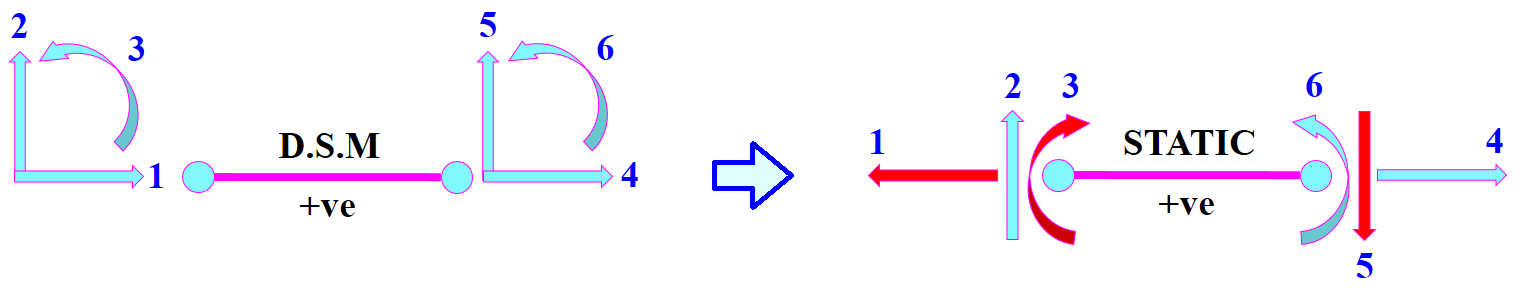
   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Visualizing Support-Reactions
 - **Rx**: horizontal reaction (KN), +ve: left to right
 - **Ry**: vertical reaction (KN), +ve: upward
 - **Rz**: resistant-moment (KNm), +ve: counter-clockwise 
 - left outer support is Support_1
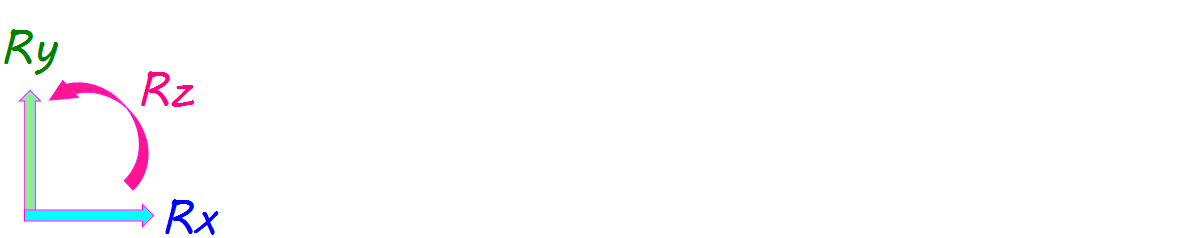


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [87]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import copy, pickle

from sympy    import *
#from My_Funcs_02 import *

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Sections & Dist-Loads & Point-Loads

In [152]:
# rectangular Distributed Load on Beams  (KN/mm)  ---  towards Ground is +ve 
w1 = 292.5/6000;     w2 = 135/4000; 

# Point-Loads on free supports  (KN)  ---  towards Ground is +ve  ---  only on "free" supports. other supports = 0
P1 = 55;             P2 = 25

# rectangle sections
# (input)          (auto)  A      I        Ks
b,h = 120,3500;     r1 = [ b*h, b*h**3/12, 1.50 ]
b,h = 120,3800;     r2 = [ b*h, b*h**3/12, 1.50 ]
b,h = 120,4000;     r3 = [ b*h, b*h**3/12, 1.50 ]

# t sections
# (input)          (auto) t1 = [ A, I, Ks ]
bf,tf = 150, 30;
bw,hw =  30,150;    t1 = T_Section( bf, tf, bw, hw )


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Structure Data

In [176]:
# (input)
L_tinyBeam = 200      #  length of tiny beams (mm) --- the smaller the better   
Method = 'DSM'  # 'DSM' 'TimoShenko'  

BAYS_WIDTH  = [      500   ,   2500  ,  2250   ,   2500   ,   3000  ,  750            ]  #  width of bays ( any amount )
DIST_LOADS  = [      w1    ,    w2   ,   w2    ,    w2    ,    w1   ,   w1            ]
SECTIONS    = [      r2    ,    r2   ,   r2    ,    r1    ,    r3   ,   r3            ]
SUPPORTS    = ['fixed' , 'free'  , 'pinned' , 'roller' , 'roller' , 'pinned' , 'fixed']  # 'fixed' 'pinned' 'roller' 'free'   Note: 'pinned' == 'roller' (Sum(Fx)==0)
POINT_LOADS = [   0    ,   P2    ,     0    ,    0     ,    0     ,     0    ,   P1   ]  #  Only on 'free' supports


# (auto)
# material
Ec = 30             # Modulus of Elasticity  ---  Concrete = 30  ---  Steel = 200  ---  (KN/mm2)
nu = 0.0            # Poisson's Rstio  ---  uncracked concrete = 0.2  ---  uncracked concrete = 0.0
Gc = Ec/(2*(1+nu))  # Shear Modulus   


MAIN_SUPPORTS = pd.DataFrame()
X=[0]
for bw in BAYS_WIDTH: X.append(X[-1]+bw)
MAIN_SUPPORTS['X (mm)'         ] = X
MAIN_SUPPORTS['Support Type'   ] = SUPPORTS
MAIN_SUPPORTS['Point Load (KN)'] = POINT_LOADS
MAIN_SUPPORTS

,X (mm),Support Type,Point Load (KN)
0,0,fixed,0
1,500,free,25
2,3000,pinned,0
3,5250,roller,0
4,7750,roller,0
5,10750,pinned,0
6,11500,fixed,55


In [177]:
MAIN_BEAMS = pd.DataFrame()
MAIN_BEAMS['L (mm)'           ] =   BAYS_WIDTH
MAIN_BEAMS['From (mm)'        ] = [ sum(BAYS_WIDTH[:i  ]) for i in range(len(BAYS_WIDTH)) ]
MAIN_BEAMS['To (mm)'          ] = [ sum(BAYS_WIDTH[:i+1]) for i in range(len(BAYS_WIDTH)) ]
MAIN_BEAMS['E (KN/mm2)'       ] = [ Ec ] * len(SECTIONS)
MAIN_BEAMS['G (KN/mm2)'       ] = [ Gc ] * len(SECTIONS)
MAIN_BEAMS['A (mm2)'          ] = [ x[0] for x in SECTIONS ]
MAIN_BEAMS['I (mm4)'          ] = [ x[1] for x in SECTIONS ]
MAIN_BEAMS['Ks'               ] = [ x[2] for x in SECTIONS ]
MAIN_BEAMS['Color'            ] =   Beam_Color( MAIN_BEAMS )   # coloring sections
MAIN_BEAMS['Dist Load (KN/mm)'] =   DIST_LOADS
MAIN_BEAMS

,L (mm),From (mm),To (mm),E (KN/mm2),G (KN/mm2),A (mm2),I (mm4),Ks,Color,Dist Load (KN/mm)
0,500,0,500,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.04875
1,2500,500,3000,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375
2,2250,3000,5250,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375
3,2500,5250,7750,30,15.0,420000,4.287500e+11,1.5,deeppink,0.03375
4,3000,7750,10750,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875
5,750,10750,11500,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875


In [178]:
Supports, SUPPORTS_IDX, Bays_Width, nPieces = Multi_Sectioner( MAIN_BEAMS, MAIN_SUPPORTS, L_tinyBeam )

In [179]:
MAIN_SUPPORTS.index     = SUPPORTS_IDX
MAIN_BEAMS['idx init']  = SUPPORTS_IDX[  :-1]
MAIN_BEAMS['idx end' ]  = SUPPORTS_IDX[+1:  ]
MAIN_BEAMS['nPieces' ]  = nPieces
MAIN_BEAMS

,L (mm),From (mm),To (mm),E (KN/mm2),G (KN/mm2),A (mm2),I (mm4),Ks,Color,Dist Load (KN/mm),idx init,idx end,nPieces
0,500,0,500,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.04875,0,3,3
1,2500,500,3000,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375,3,16,13
2,2250,3000,5250,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375,16,27,11
3,2500,5250,7750,30,15.0,420000,4.287500e+11,1.5,deeppink,0.03375,27,40,13
4,3000,7750,10750,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875,40,55,15
5,750,10750,11500,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875,55,59,4


In [180]:
All_Supports = pd.DataFrame()
All_Supports[ 'Support Type' ] = Supports

All_Beams = Make_All_Beams( MAIN_BEAMS, Bays_Width )
All_Beams.tail(2)

,L (mm),E (KN/mm2),G (KN/mm2),A (mm2),I (mm4),Ks,Color,Dist Load (KN/mm)
57,200,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875
58,150,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875


In [181]:
Points, CnB  =  PC( Bays_Width )                                                         # Points & Connectivity Matrices
[NOP, NOD, RD, FD, NFD, NB, IndxB] = Static_Coeff( Points, CnB, Bays_Width, Supports )   # Finding Static Coefficients

In [182]:
NF = Nodal_Forces( Points, POINT_LOADS, NOD, MAIN_BEAMS )   # Nodal Forces

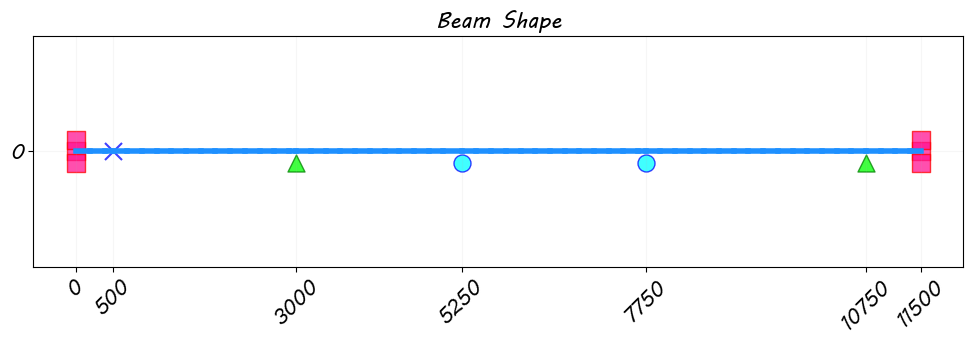

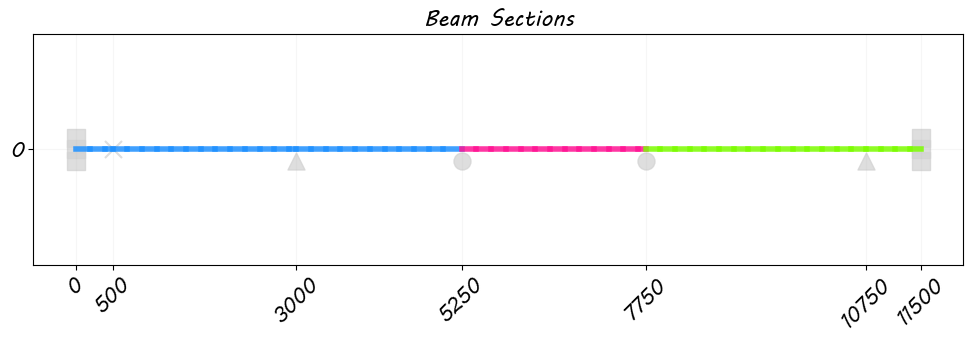

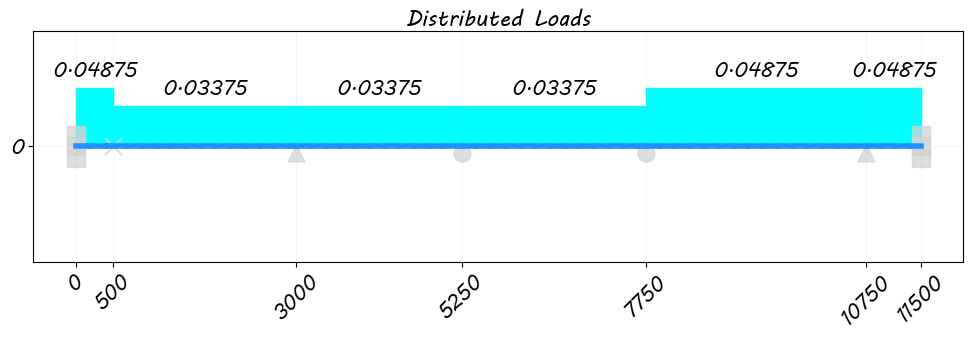

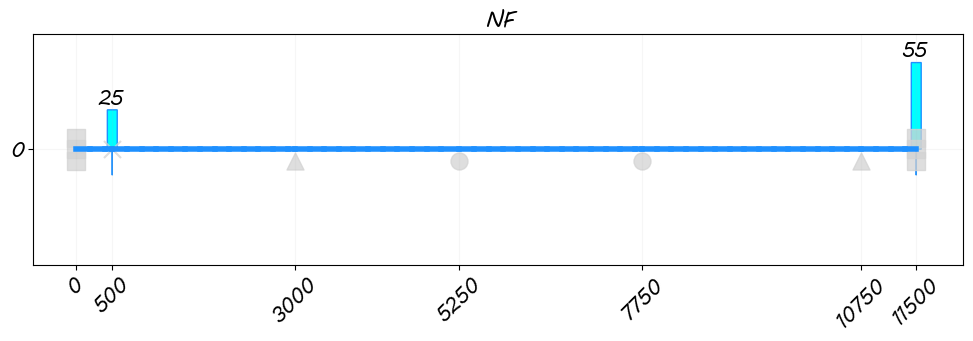

In [183]:
Beam_Shape(           Points, CnB, BAYS_WIDTH, Bays_Width, Supports                        )   # checking beams shape
Plot_Sections(        Points, CnB, BAYS_WIDTH, Bays_Width, Supports, All_Beams             )   # checking beams sections
Beam_Dist_Load_Shape( Points, CnB, BAYS_WIDTH, Bays_Width, Supports, All_Beams, DIST_LOADS )   # checking beams dist. loads
NF_Shape(             Points, CnB, BAYS_WIDTH, Bays_Width, Supports, NF                    )   # checking beams NFs

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Analysis

In [184]:
# Ke Qf 
KE,QF, LB,TB,keB,KeB,qfB  =  KeQf( Points,  NOD, CnB, NB, IndxB, All_Beams, Method )

# performing analysis
if Method=='DSM':
    print('DSM Analysis initiated ...')
    qB, R, U, df_XYVM = Analyze_Beam_DSM(        NF,  NOD,  FD, KE, QF, NB, IndxB, TB, keB, KeB, qfB, All_Beams )
elif Method=='TimoShenko':
    print('TimoShenko Analysis initiated ...')
    qB, R, U, df_XYVM = Analyze_Beam_TimoShenko( NF,  NOD,  FD, KE, QF, NB, IndxB, TB, keB, KeB, qfB, All_Beams )

print('Analysis finished.')

DSM Analysis initiated ...
Analysis finished.


In [185]:
df_XYVM

,X,Y,V,M
0,0,0.000000e+00,84.005014,-38400.268723
1,10,-1.157866e-07,83.517514,-37562.656082
2,20,-4.597592e-07,83.030014,-36729.918441
3,30,-1.026859e-06,82.542514,-35902.055800
4,40,-1.812057e-06,82.055014,-35079.068159
...,...,...,...,...
1204,11460,5.542508e-07,48.527593,12027.450736
1205,11470,3.154716e-07,48.040093,12510.289163
1206,11480,1.418480e-07,47.552593,12988.252591
1207,11490,3.586950e-08,47.065093,13461.341019


In [186]:
IDX_INIT, IDX_END = [0], []
I = df_XYVM.index.tolist()[1:-1]
for i in I:
    x0 = df_XYVM.loc[i  ,'X']
    x1 = df_XYVM.loc[i+1,'X']
    if x0==x1:
        IDX_END.append(  i   )
        IDX_INIT.append( i+1 )
i_end = df_XYVM.index[-1]
IDX_END.append( i_end )

In [187]:
MAIN_BEAMS['idx end'] = MAIN_BEAMS['idx end']-1
MAIN_BEAMS

,L (mm),From (mm),To (mm),E (KN/mm2),G (KN/mm2),A (mm2),I (mm4),Ks,Color,Dist Load (KN/mm),idx init,idx end,nPieces
0,500,0,500,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.04875,0,2,3
1,2500,500,3000,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375,3,15,13
2,2250,3000,5250,30,15.0,456000,5.487200e+11,1.5,dodgerblue,0.03375,16,26,11
3,2500,5250,7750,30,15.0,420000,4.287500e+11,1.5,deeppink,0.03375,27,39,13
4,3000,7750,10750,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875,40,54,15
5,750,10750,11500,30,15.0,480000,6.400000e+11,1.5,lawngreen,0.04875,55,58,4


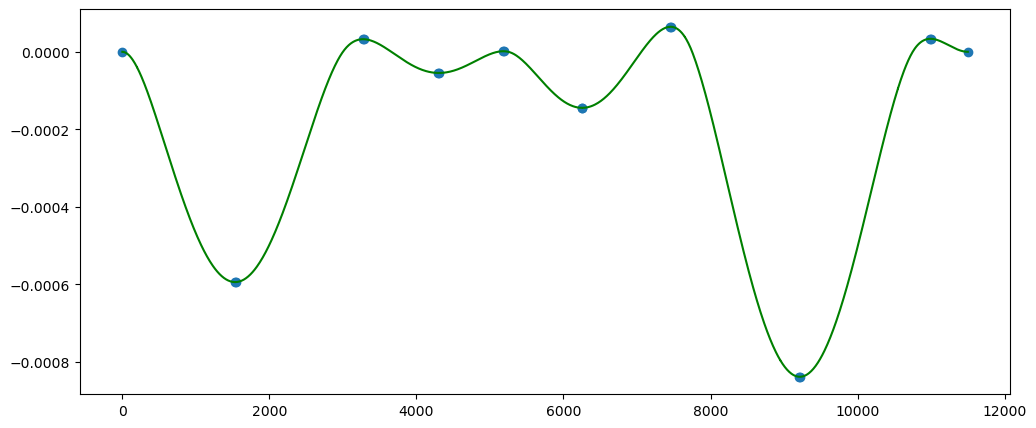

In [188]:
XX = df_XYVM['X'].copy().tolist()
YY = df_XYVM['Y'].copy().tolist()

ZERO = 0.00*10**(-12)
X_MxMn, Y_MxMn = [],[]

if abs(YY[0]) >= ZERO:
    X_MxMn.append(XX[0])
    Y_MxMn.append(YY[0])
    
for i in range(len(YY)):
    try:
        a,b, c, d,e  =  YY[i-10], YY[i-2], YY[i], YY[i+2], YY[i+10] 
        if  abs(c) >= ZERO: 
            if (a<b and b<c and c>d and d>e ) or (a>b and b>c and c<d and d<e ):
                Y_MxMn.append(YY[i])
                X_MxMn.append(XX[i])
    except:
        pass
    
if abs(YY[-1]) >= ZERO:
    X_MxMn.append(XX[-1])
    Y_MxMn.append(YY[-1])

# Uy
df_Uy = pd.DataFrame([X_MxMn,Y_MxMn]).T
df_Uy.columns = ['X (mm)','Uy (mm)']

fig, ax = plt.subplots( figsize=(12,5) )
ax.plot(XX,YY,'-g')
ax.scatter( df_Uy['X (mm)'],df_Uy['Uy (mm)'] )
plt.show()

In [189]:
MAIN_SUPPORTS

,X (mm),Support Type,Point Load (KN)
0,0,fixed,0
3,500,free,25
16,3000,pinned,0
27,5250,roller,0
40,7750,roller,0
55,10750,pinned,0
59,11500,fixed,55


In [190]:
Supp_IDX = []
idx_init, idx_end = [0], []
for i in MAIN_BEAMS.index:
    From = MAIN_BEAMS.loc[i,'From (mm)']
    To   = MAIN_BEAMS.loc[i, 'To (mm)' ]
    for i in range(len(XX)-1):
        if XX[i]==XX[i+1] and XX[i+1]==To:
            idx_end.append(  i )
            idx_init.append(i+1)
idx_end.append( len(XX)-1 )

MAIN_BEAMS['idx init'] = idx_init
MAIN_BEAMS['idx end' ] = idx_end
MAIN_BEAMS[['idx init','idx end']]

,idx init,idx end
0,0,52
1,53,315
2,316,551
3,552,814
4,815,1129
5,1130,1208


In [191]:
FIXED_X = []
for i in MAIN_SUPPORTS.index:
    x = MAIN_SUPPORTS.loc[i,'X (mm)']
    s = MAIN_SUPPORTS.loc[i,'Support Type']
    if s == 'fixed':
        FIXED_X.append(x)
FIXED_X

[0, 11500]

In [192]:
MAIN_SUPPORTS

,X (mm),Support Type,Point Load (KN)
0,0,fixed,0
3,500,free,25
16,3000,pinned,0
27,5250,roller,0
40,7750,roller,0
55,10750,pinned,0
59,11500,fixed,55


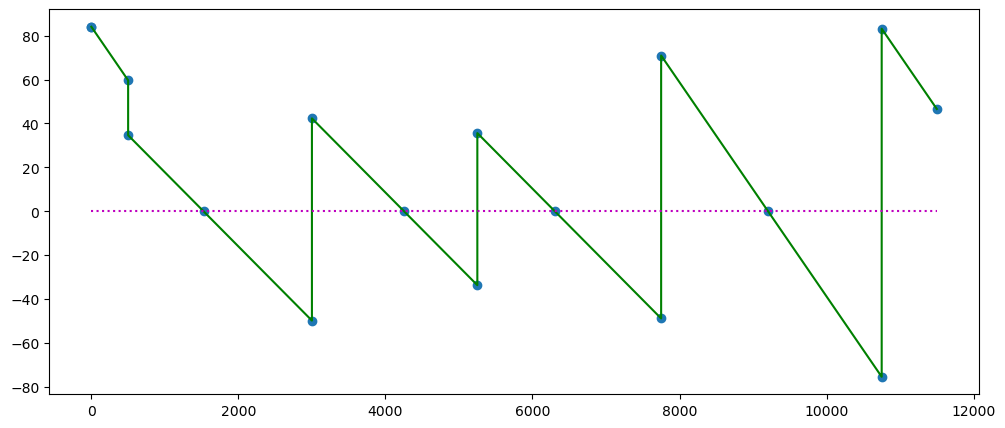

In [193]:
# df_V
#I = list(set( MAIN_BEAMS['idx init'].copy().tolist() + MAIN_BEAMS['idx end'].copy().tolist() ))
#I.sort()
XX = df_XYVM['X'].copy().tolist()
VV = df_XYVM['V'].copy().tolist() 

X, V = [ XX[0] ],[ VV[0] ] 
for i in range(len(VV)-1):
    
    x = XX[i]
    if x in MAIN_SUPPORTS['X (mm)'].tolist():
        v = VV[i]
        X.append(x)
        V.append(v)
        
    v0, v1 = VV[i], VV[i+1]
    if v0*v1 < 0:
        c = abs(v0) / ( abs(v0)+abs(v1) )
        x0, x1 = XX[i], XX[i+1]
        dx = x1-x0
        x  = x0 + c*dx
        if x not in X:
            X.append(x)
            V.append(0)
            
X.append( XX[-1] )
V.append( VV[-1] )            
            
df_V = pd.DataFrame([X,V]).T
df_V.columns = ['X (mm)','V (KN)']
#df_V = df_V.sort_values(['X (mm)'],ascending=[True])
df_V.index = range(df_V.shape[0])

fig, ax = plt.subplots( figsize=(12,5) )
ax.plot(df_V['X (mm)'],df_V['V (KN)'],'-g')
ax.plot([0,max(X)],[0,0],':m')
ax.scatter( df_V['X (mm)'],df_V['V (KN)'] )
plt.show()

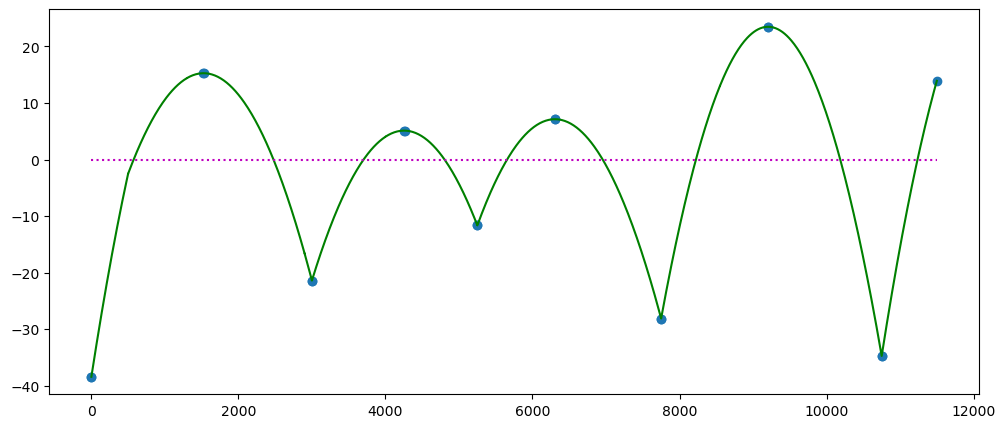

In [194]:
# df_M
XX =  df_XYVM['X'].copy().tolist()
MM = (df_XYVM['M'].copy()/10**3).tolist()

X, M = [ XX[0] ], [ MM[0] ]
for i in range(0,len(MM)):
    try:
        a, b, c, d, e = MM[i-5], MM[i-2], MM[i], MM[i+2] , MM[i+5]
        if (a<b and b<c and c>d and d>e) or (a>b and b>c and c<d and d<e):
            x = XX[i]
            m = MM[i]
            X.append(x)
            M.append(m)
    except:
        pass

X.append(XX[-1])
M.append(MM[-1])

for x in FIXED_X:
    for i in range(len(XX)-1):
        if x == XX[i]:
            m = MM[i]
            X.append(x)
            M.append(m)

df_M = pd.DataFrame([X,M]).T
df_M.columns = ['X (mm)','M (KNm)']
df_M = df_M.sort_values(['X (mm)'],ascending=[True])
df_M.index = range(df_M.shape[0])

fig, ax = plt.subplots( figsize=(12,5) )
ax.plot(XX,MM,'-g')
ax.plot([0,max(XX)],[0,0],':m')
ax.scatter( df_M['X (mm)'],df_M['M (KNm)'] )
plt.show()

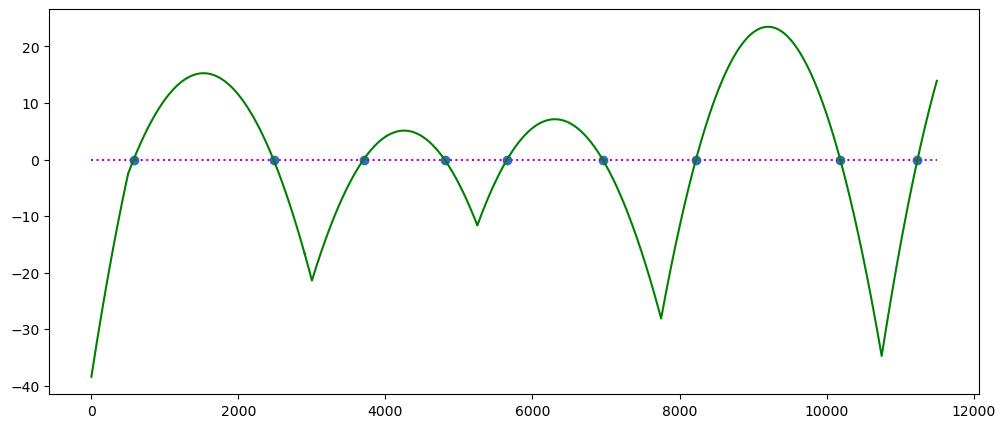

In [195]:
# Flex 

Flex = []
for i in range(len(MM)-1):
    m0, m1 = MM[i], MM[i+1]
    if m0*m1 < 0:
        c = abs(m0) / ( abs(m0)+abs(m1) )
        x0, x1 = XX[i], XX[i+1]
        dx = x1-x0
        x  = x0 + c*dx
        Flex.append(x)
        
fig, ax = plt.subplots( figsize=(12,5) )
ax.plot(XX,MM,'-g')
ax.plot([0,max(XX)],[0,0],':m')
ax.scatter( Flex, [0]*len(Flex) )
plt.show()

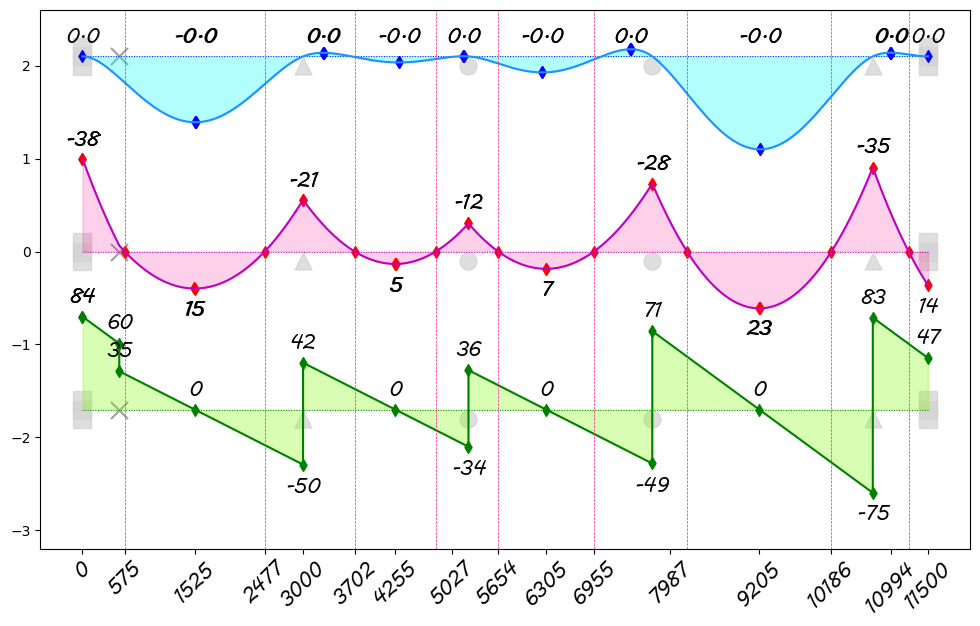

In [227]:
Y_MAX = max(abs(np.array(YY)))
V_MAX = max(abs(np.array(VV)))
M_MAX = max(abs(np.array(MM)))

nt = 2.1
nb = 1.7

fig, ax = plt.subplots( figsize=(12,7) )

ax.plot( [0,XX[-1]], [+nt,+nt],':b', lw=.7 )
ax.plot( [0,XX[-1]], [  0,  0],':m', lw=.7 )
ax.plot( [0,XX[-1]], [-nb,-nb],':g', lw=.7 )

# Supports
for i in Points.index:
    x = Points.loc[i,'x']
    y = Points.loc[i,'y']
    if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray'  , y-0.0
    elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray'  , y-0.1
    elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray'  , y-0.1
    elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'gray'     , 'gray'       , y-0.0
    elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'gray'     , 'gray'       , y-0.0
    ax.scatter( x, y+nt, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
    ax.scatter( x, y   , marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
    ax.scatter( x, y-nb, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
    if   Supports[i]=='fixed' :
        ax.scatter( x, y+0.1+nt, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        ax.scatter( x, y+0.1   , marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        ax.scatter( x, y+0.1-nb, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        ax.scatter( x, y-0.1+nt, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        ax.scatter( x, y-0.1   , marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        ax.scatter( x, y-0.1-nb, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )

ax.plot( XX, +nt+np.array(YY)/Y_MAX,'dodgerblue' )
ax.plot( XX,    -np.array(MM)/M_MAX,'-m'         )
ax.plot( XX, -nb+np.array(VV)/V_MAX,'-g'         )

ax.fill_between( XX, +nt+np.array(YY)*0, +nt+np.array(YY)/Y_MAX, color='cyan'     , alpha=0.3 )
ax.fill_between( XX,    -np.array(MM)*0,    -np.array(MM)/M_MAX, color='deeppink' , alpha=0.2 )
ax.fill_between( XX, -nb+np.array(VV)*0, -nb+np.array(VV)/V_MAX, color='lawngreen', alpha=0.3 )

ax.scatter( df_Uy['X (mm)'], +nt+df_Uy['Uy (mm)']/Y_MAX, marker='d', ec='b', fc='b' )
ax.scatter( df_M[ 'X (mm)'],    -df_M[ 'M (KNm)']/M_MAX, marker='d', ec='r', fc='r' )
ax.scatter( Flex           ,  [0] *len(Flex)           , marker='d', ec='r', fc='r' )
ax.scatter( df_V[ 'X (mm)'],  -nb+df_V[ 'V (KN)']/V_MAX, marker='d', ec='g', fc='g' )

Y_LIM = [-nb-1.5,+nt+.5]

for f in Flex: plt.plot([f,f],Y_LIM,ls='--',lw=.5,c='deeppink')
    
for i in df_Uy.index:   
    uy = np.round( df_Uy.loc[i,'Uy (mm)'], 2 )
    if uy>=0: plt.text( df_Uy.loc[i,'X (mm)'],  nt+.15+uy/Y_MAX, str(uy), ha='center', font='MV BOLI', fontsize=14 )
    else    : plt.text( df_Uy.loc[i,'X (mm)'],  nt-.30+uy/Y_MAX, str(uy), ha='center', font='MV BOLI', fontsize=14 )
for i in df_M.index :  
    m = -int(np.round(df_M.loc[ i,'M (KNm)'],0))
    if m>=0 : plt.text( df_M.loc[ i,'X (mm)'],    +.15+m/M_MAX,  str(-m),  ha='center', font='MV BOLI', fontsize=14 )
    else    : plt.text( df_M.loc[ i,'X (mm)'],    -.30+m/M_MAX,  str(-m),  ha='center', font='MV BOLI', fontsize=14 )
for i in df_V.index :  
    v = int(np.round(df_V.loc[ i,'V (KN)'],0))
    if v>=0 : plt.text( df_V.loc[ i,'X (mm)'], -nb+.15+v/V_MAX,  str(v),   ha='center', font='MV BOLI', fontsize=14 )
    else    : plt.text( df_V.loc[ i,'X (mm)'], -nb-.30+v/V_MAX,  str(v),   ha='center', font='MV BOLI', fontsize=14 )

# xticks
Xwalk = list( set( Flex + df_M['X (mm)'].tolist() + df_M['X (mm)'].tolist() ))   #  + df_Uy['X (mm)'].tolist()
Xwalk.sort()

A, B, i = Xwalk, [], 0
while(i<len(A)):
    try:
        a1, a0 = A[i+1], A[i]
        if A[i+1]-A[i] > 500:
            b, i = int(np.round(a0,0)), i+1
        else:
            b, i = int(np.round((a0+a1)/2,0)), i+2
        B.append(b)
    except:
        i = i+1
B.append( A[-1] )
Xwalk = B

xtks = np.array(Xwalk,dtype='f8') 
ax.set_xticks( xtks )
plt.xticks(font='MV BOLI',rotation=45,fontsize=14)    
    
plt.ylim(Y_LIM)
plt.show() 

In [273]:
MAIN_SUPPORTS.index = range(MAIN_SUPPORTS.shape[0])
Keep = [0]
for i in MAIN_SUPPORTS.index[1:-1]:
    supp = MAIN_SUPPORTS.loc[i,'Support Type']
    if supp != 'free':  Keep.append(i)
Keep.append(MAIN_SUPPORTS.index[-1])
NON_FREE_SUPPORTS = MAIN_SUPPORTS.loc[Keep,:].copy()
NON_FREE_SUPPORTS.index = range(NON_FREE_SUPPORTS.shape[0])
NON_FREE_SUPPORTS

,X (mm),Support Type,Point Load (KN)
0,0,fixed,0
1,3000,pinned,0
2,5250,roller,0
3,7750,roller,0
4,10750,pinned,0
5,11500,fixed,55


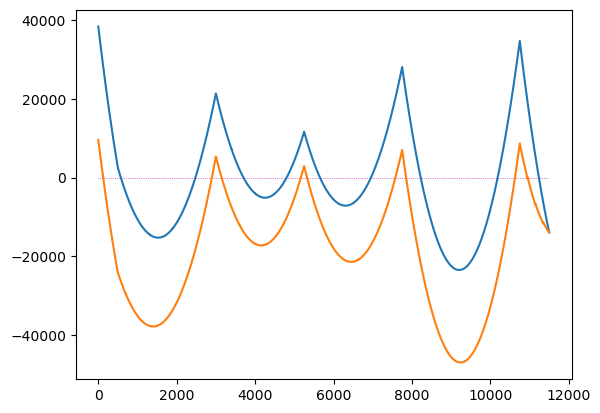

In [334]:
redist = 0.75

df = df_XYVM[['X','M']].copy()
df.drop_duplicates()
df.index = range(df.shape[0])

X, M_redist = [], []

I = NON_FREE_SUPPORTS.index.tolist()

for i in I:
    L2R, R2L = True, True
    try:
        if i==0 and NON_FREE_SUPPORTS.loc[0,'Support Type']=='free':   
            L2R, R2L = False, False
    except:
        pass
    try:
        if i==1 and NON_FREE_SUPPORTS.loc[1,'Support Type']!='fixed'and NON_FREE_SUPPORTS.loc[0,'Support Type']=='free':
            L2R      = False
    except:
        pass
    try:
        if i==I[-3] and NON_FREE_SUPPORTS.loc[I[-2],'Support Type']!='fixed' and NON_FREE_SUPPORTS.loc[I[-1],'Support Type']=='free':
            R2L      =        False
    except:
        pass
    try:
        if i==I[-2] and NON_FREE_SUPPORTS.loc[I[-1],'Support Type']=='free':   
            L2R, R2L = False, False
    except:
        pass
     
    try:
        x0, x1 = NON_FREE_SUPPORTS.loc[i,'X (mm)'], NON_FREE_SUPPORTS.loc[i+1,'X (mm)']
        Dummy, M = [], []
        for j in df.index:
            x = df.loc[j,'X']
            if x0<=x and x<=x1:
                m = df_XYVM.loc[j,'M'] 
                Dummy.append(x)
                M.append(m) 
                
        if Dummy[0]  == Dummy[1] : M = M[+1:]
        if Dummy[-2] == Dummy[-1]: M = M[:-1]
            
        #print(x0,x1, L2R,R2L)
        if L2R:              
            m_red  = min( 0, M[0]*redist )
            n_step = len(M)-1
            d_red  = m_red / n_step
            for k in np.arange(0,len(M),1):
                M[k]  = M[k]  - m_red
                m_red = m_red - d_red
        if R2L:
            m_red  = min( 0, M[-1]*redist )
            n_step = len(M)-1
            d_red  = m_red / n_step
            for k in np.arange(len(M)-1,-1,-1):
                M[k]  = M[k]  - m_red
                m_red = m_red - d_red
        for m in M:
            M_redist.append(m)
    except:
        pass
        
df_XYVM['Mred'] = M_redist

plt.plot([0,df_XYVM['X'].max()],[0,0],":m",lw=.5)
plt.plot(df_XYVM['X'],-df_XYVM['M'])
plt.plot(df_XYVM['X'],-df_XYVM['Mred'])

In [ ]:
X_MxMn, Y_MxMn = [],[]
for i in [0, len(YY)-1]:
    if abs(YY[i]) >= 10**(-3):
        X_MxMn.append( XX[i] )
        Y_MxMn.append( YY[i] )
         
for i in MAIN_BEAMS.index:
    idx_init = MAIN_BEAMS.loc[i,'idx init']
    idx_end  = MAIN_BEAMS.loc[i,'idx end' ]
    for i in range(idx_init,idx_end):
        try:
            a,b, c, d,e  =  YY[i-2], YY[i-1], YY[i], YY[i+1], YY[i+2] 
            if  abs(c) >= 10**(-6): 
                if (a<b and b<c and c>d and d>e ) or (a>b and b>c and c<d and d<e ):
                    Y_MxMn.append(YY[i])
                    X_MxMn.append(XX[i])
        except:
            pass

# Uy
df_Uy = pd.DataFrame([X_MxMn,Y_MxMn]).T
df_Uy.columns = ['X (mm)','Uy (mm)']

fig, ax = plt.subplots( figsize=(12,5) )
ax.plot(XX,YY,'-g')
ax.scatter( df_Uy['X (mm)'],df_Uy['Uy (mm)'] )
plt.show()

In [ ]:
df_XYVM.head(2)

In [ ]:
fig, ax = plt.subplots( figsize=(12,5) )
ax.plot( df_XYVM['X'],df_XYVM['Y'],'-go' )

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Post Analysis

In [ ]:
# Converting Directions (D.S.M. to Standard.Static) 
# qX  --->  qXs
if Method=='DSM':
    [ qBs ] = D2S( NB, qB, R )
elif Method=='TimoShenko':
    R  = -R
    [ qBs ] = D2S( NB, qB, R )

# finding Global Displacements, Support Reactions & Internal Member Forces
[ Uxyz, Rxyz, AxB,VB,MB ] = xyzNVM( NB, U, R, qBs )

# Adding Internal Forces to Beams
All_Beams = Add_member_forces( AxB,VB,MB, All_Beams )
if Method=='TimoShenko': 
    All_Beams['Shear_left' ] = -1 * All_Beams['Shear_left' ]
    All_Beams['Shear_right'] = -1 * All_Beams['Shear_right']

# Checking Accuracy:   Acc = Sum( Ry ) / Sum( dist. load + Point load )
Accuracy = Find_Accuracy( BAYS_WIDTH, DIST_LOADS, Supports, NF, R )
print( 'Accuracy  =  ' + str(Accuracy) + ' %' )

# Visualizing Support Reactions
Plot_Support_Reactions( Rxyz, nPieces )

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Moment Re-Distribution

In [ ]:
# finding Max or Min Uy of Main bays
Uy_MxMn = Find_Uy_MxMn( Points, SUPPORTS_IDX, Supports, NB, Uxyz )

# plotting deformed-shape
Plot_Deformed(  Points, SUPPORTS_IDX, Supports, BAYS_WIDTH, Bays_Width, All_Beams, CnB,NB, Uxyz, Uy_MxMn, 'M'  ); print()
#Plot_Deformed( Points, SUPPORTS_IDX, Supports, BAYS_WIDTH, Bays_Width, All_Beams, CnB,NB, Uxyz, Uy_MxMn, 'V'  ); print()
#Plot_Deformed( Points, SUPPORTS_IDX, Supports, BAYS_WIDTH, Bays_Width, All_Beams, CnB,NB, Uxyz, Uy_MxMn, None ); print()


In [ ]:
# (input)
redist = 0.20

# (auto)
M_redist         = Moment_Redistribute( SUPPORTS_IDX, Supports, All_Beams, redist )
M_redist.tail(3) 

In [ ]:
MAIN_BEAMS = df_Main_with_Redist(MAIN_BEAMS, M_redist, All_Beams, SUPPORTS_IDX, SUPPORTS, NB)
MAIN_BEAMS

In [ ]:
[ M_MIN_redist, M_MAX_redist ] = Find_M_MxMn( NOP, NB, M_redist )
[ M_MIN_redist, M_MAX_redist ]

In [ ]:
Flex_redist = Find_Flexure_Points( Points, NOP, M_redist )
Flex_redist

In [ ]:
MAIN_BEAMS

In [ ]:
Plot_Moment( Points, Supports, BAYS_WIDTH, Bays_Width, CnB,NB,M_redist, M_MIN_redist, M_MAX_redist, Flex_redist, redist )   # after  redist
Plot_Shear_Redist( MAIN_BEAMS, redist, Points, Supports )

In [ ]:
# finding 0, Max or Min Shear of Main bays
[ V_Shear, V_MxMn ] = Find_V_MxMn( NB, All_Beams, SUPPORTS_IDX, Supports, BAYS_WIDTH, Bays_Width, L_tinyBeam ) 

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Save

In [ ]:
pickle.dump( Uy_MxMn,  open('Uy_MxMn','wb') )  # save
pickle.dump( V_MxMn ,  open('V_MxMn' ,'wb') )  # save
pickle.dump( Flex   ,  open('Flex'   ,'wb') )  # save
pickle.dump( M_MIN  ,  open('M_MIN'  ,'wb') )  # save
pickle.dump( M_MAX  ,  open('M_MAX'  ,'wb') )  # save
pickle.dump( Rxyz   ,  open('Rxyz'   ,'wb') )  # save

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Load

In [ ]:
Uy_MxMn = pickle.load( open('Uy_MxMn','rb') )  # load
V_MxMn  = pickle.load( open('V_MxMn' ,'rb') )  # load
Flex    = pickle.load( open('Flex'   ,'rb') )  # load
M_MIN   = pickle.load( open('M_MIN'  ,'rb') )  # load
M_MAX   = pickle.load( open('M_MAX'  ,'rb') )  # load
Rxyz    = pickle.load( open('Rxyz'   ,'rb') )  # load

##### 

##### 

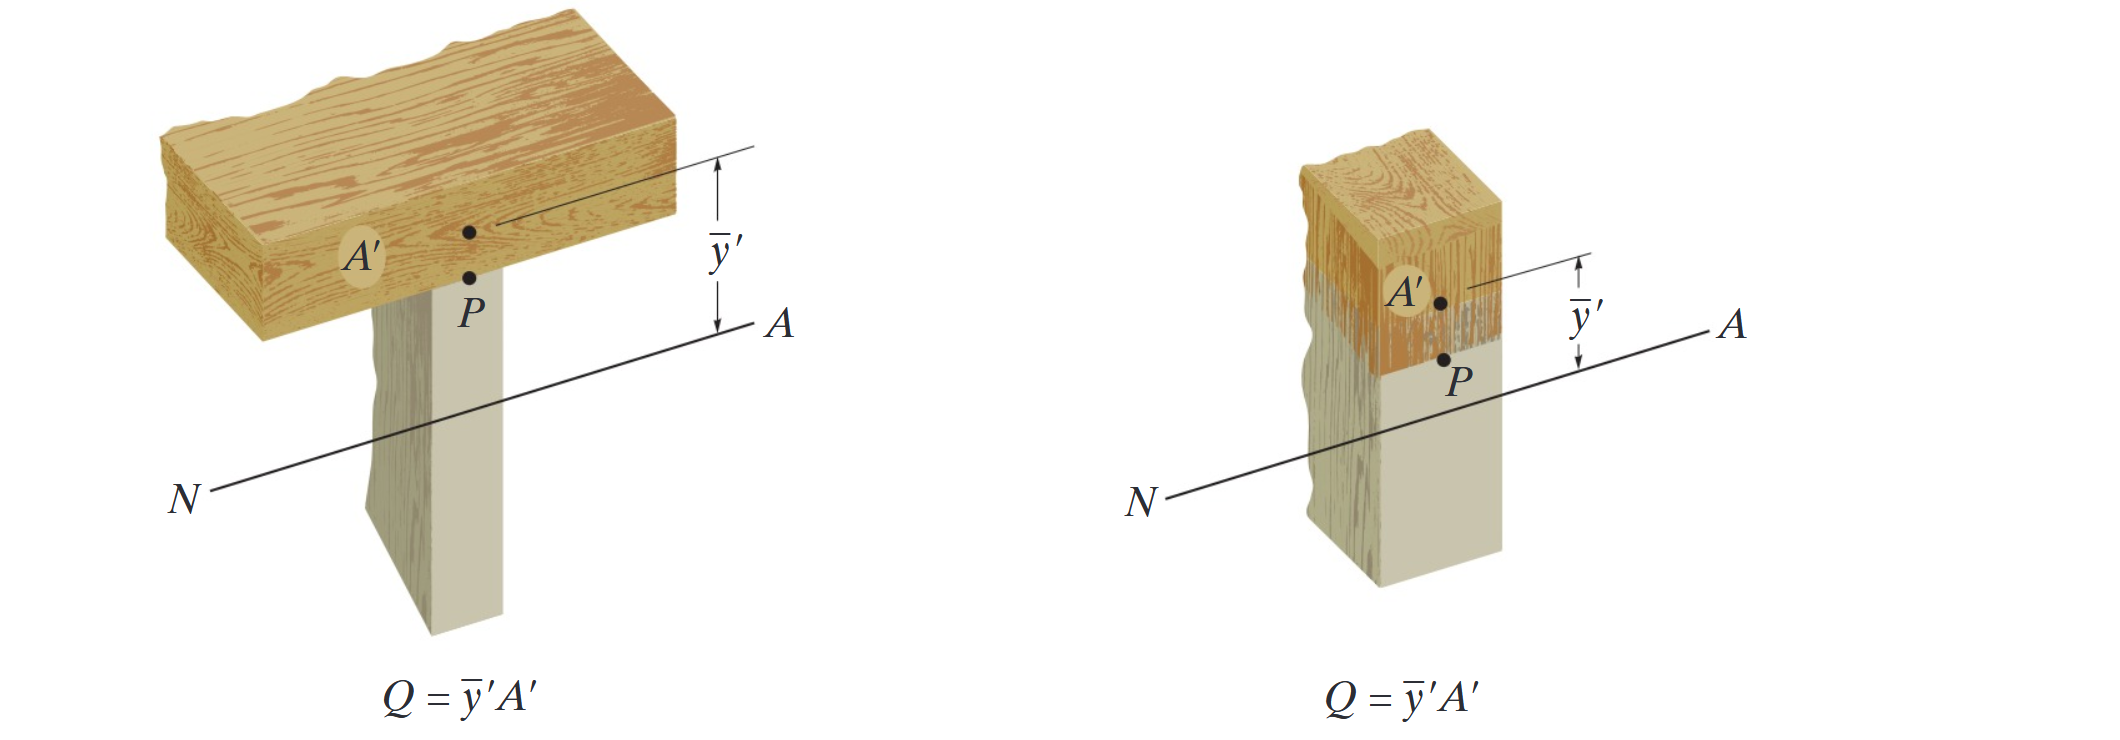

In [ ]:
h  = 180
bf = 150
tf =  30
bw =  30
hw = h - tf

# A
Af = bf*tf
Aw = bw*hw
A  = Af+Aw

# Y
Yf = h - tf/2
Yw = hw/2
Y  = (Af*Yf + Aw*Yw ) / (Af+Aw)

# Q
Yp = h - Y - tf/2
Ap = Af
Q  = Yp * Ap

# I
If = bf*tf**3/12
Iw = bw*hw**3/12
I  = If + Af*(Yf-Y)**2 + Iw + Aw*(Yw-Y)**2

# Ks
# Taw_max = (V*Q)/(I*t) = Ks*(V/A)
# Ks = (A*Q)/(I*t)
t  = bw
Ks = (A*Q) / (I*t) 
Ks = np.round(Ks,2)
Ks

In [ ]:
nu = 0.0   #  cracked: 0.0   uncracked: 0.2
G  = E / (2*(1+nu))